# VoxelMorph


In [1]:
from __future__ import annotations
from collections import defaultdict
from importlib import reload
import matplotlib.pyplot as plt; plt.style.use('seaborn-pastel'); plt.set_cmap('bone')
import matplotlib.image as mpimg
import neurite as ne
import numpy as np
import os; os.environ['VXM_BACKEND'] = 'pytorch'
from pathlib import Path
import sys
from time import perf_counter
import torch
import torchvision
from tqdm import tqdm 
import random
import voxelmorph as vm
print(sys.version)
print('numpy version', np.__version__)
print('torch version', torch.__version__)
print(f'voxelmorph using {vm.py.utils.get_backend()} backend')

2022-05-14 17:06:47.508884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-05-14 17:06:47.508925: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
numpy version 1.21.2
torch version 1.11.0
voxelmorph using pytorch backend


<Figure size 432x288 with 0 Axes>

## data

### datasets

* [mnist](https://pytorch.org/vision/stable/datasets.html)
* [fashionmnist](https://pytorch.org/vision/stable/datasets.html)
* [omniglot](https://pytorch.org/vision/stable/datasets.html)
* [morphomnist](https://github.com/dccastro/Morpho-MNIST)
* [caltech 101 silhouettes](https://people.cs.umass.edu/~marlin/data.shtml)

In [2]:
pwd

'/mnt/qtim/registration'

In [3]:
data_dir = Path('datasets')
data_dir.mkdir(exist_ok=True)

In [4]:
mnist_dir = data_dir / 'mnist'
mnist_dir.mkdir(exist_ok=True)
mnist = torchvision.datasets.MNIST(root=mnist_dir, download=True)

fashionmnist_dir = data_dir / 'fashionmnist'
fashionmnist_dir.mkdir(exist_ok=True)
fashionmnist = torchvision.datasets.FashionMNIST(root=fashionmnist_dir, download=True)

omniglot_dir = data_dir / 'omniglot'
omniglot_dir.mkdir(exist_ok=True)
omniglot = torchvision.datasets.Omniglot(root=omniglot_dir, download=True)

Files already downloaded and verified


### partition by class

In [5]:
def filter_by_class(data, labels, class_to_keep: int = 0):
    indexer = labels == class_to_keep
    filtered_data = data[indexer]
    filtered_labels = labels[indexer]
    return filtered_data, filtered_labels

def partition_by_class(data, labels, classes):
    class_partitions = {}
    for k in classes:
        class_partitions[k] = filter_by_class(data, labels, k)
    return class_partitions
       

In [6]:
mnist_data = mnist.data.numpy()
mnist_labels = mnist.targets.numpy()
mnist_classes = np.unique(mnist_labels)
mnist_partitions = partition_by_class(mnist_data, mnist_labels, mnist_classes)

In [7]:
fashionmnist_data = fashionmnist.data.numpy()
fashionmnist_labels = fashionmnist.targets.numpy()
fashionmnist_classes = np.unique(fashionmnist_labels)
fashionmnist_partitions = partition_by_class(fashionmnist_data, fashionmnist_labels, fashionmnist_classes)

### split data

In [8]:
def get_data_split(data, labels, val_split=0.1, test_split=0.2):
    data = np.asarray(data)
    labels = np.asarray(labels)
    n = data.shape[0]
    assert n == labels.shape[0]
    index = list(range(n))
    random.shuffle(index)
    num_test = round(test_split * n)
    num_dev = n - num_test
    num_val = round(num_dev * val_split)
    num_train = num_dev - num_val
    train_index = index[:num_train]
    val_index = index[num_train:num_train+num_val]
    test_index = index[-num_test:]
    return {
        'train_data': data[train_index],
        'train_labels': labels[train_index],
        'val_data': data[val_index],
        'val_labels': labels[val_index],
        'test_data': data[test_index],
        'test_labels': labels[test_index],
    }

### choose class

In [135]:
zero_data = mnist_partitions[0]
zero_split = get_data_split(*zero_data)
one_data = mnist_partitions[1]
one_split = get_data_split(*one_data)
two_data = mnist_partitions[2]
two_split = get_data_split(*two_data)
three_data = mnist_partitions[3]
three_split = get_data_split(*three_data)
four_data = mnist_partitions[4]
four_split = get_data_split(*four_data)
five_data = mnist_partitions[5]
five_split = get_data_split(*five_data)
six_data = mnist_partitions[6]
six_split = get_data_split(*six_data)
seven_data = mnist_partitions[7]
seven_split = get_data_split(*seven_data)
eight_data = mnist_partitions[8]
eight_split = get_data_split(*eight_data)
nine_data = mnist_partitions[9]
nine_split = get_data_split(*nine_data)

In [10]:
sandal_data = fashionmnist_partitions[5]
sandal_split = get_data_split(*sandal_data)

sneaker_data = fashionmnist_partitions[7]
sneaker_split = get_data_split(*sneaker_data)

boot_data = fashionmnist_partitions[9]
boot_split = get_data_split(*boot_data)

### dataset class

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        data: np.ndarray, 
        labels: np.ndarray, 
        normalize: bool = True,
        padding: None | tuple[int, int] = (32, 32), 
        transforms: None | list[torchvision.transforms] = [
            # torchvision.transforms.Pad((32, 32), fill=0),
            torchvision.transforms.ToTensor(),
        ],
    ):
        self.data = data
        self.labels = labels
        self.normalize = normalize
        self.padding = padding
        self.transforms = torchvision.transforms.Compose(transforms)

    def __len__(self):
        return self.data.shape[0] - 1

    def __getitem__(self, index):
        moving_image = self.data[index]
        fixed_image = self.data[index+1]
        if self.transforms:
            moving_image = self.transforms(moving_image)
            fixed_image = self.transforms(fixed_image)
        if self.padding:
            moving_image = self.pad(moving_image)
            fixed_image = self.pad(fixed_image)
            
        return torch.cat([moving_image, fixed_image], 0)
    
    def normalize(self, image):
        pass
    
    def pad(self, image):
        # only handles case when pad > size
        w, h = image.squeeze().shape
        assert self.padding[0] >= w, 'width padding too small'
        assert self.padding[1] >= h, 'height padding too small'
        w_diff = self.padding[0] - w
        h_diff = self.padding[1] - h
        w_pad = w_diff // 2
        h_pad = h_diff // 2
        padding = w_pad, w_diff - w_pad, h_pad, h_diff - h_pad
        image = torch.nn.functional.pad(image, padding, 'constant', 0)
        return image

In [12]:
def make_datasets(data_split):
    train_dataset = Dataset(data_split['train_data'], data_split['train_labels'])
    val_dataset = Dataset(data_split['val_data'], data_split['val_labels'])
    test_dataset = Dataset(data_split['test_data'], data_split['test_labels'])
    return train_dataset, val_dataset, test_dataset

def show(images):
    number_of_images = len(images)
    fig, ax = plt.subplots(ncols=number_of_images)
    for i in range(number_of_images):
        ax[i].imshow(images[i])
    plt.show()

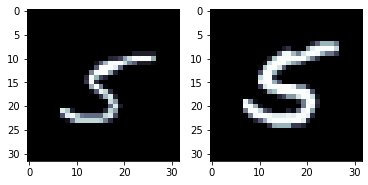

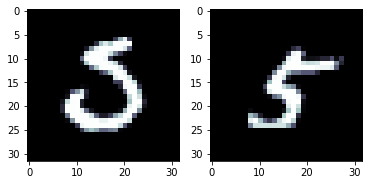

In [136]:
zero_train_dataset, zero_val_dataset, zero_test_dataset = make_datasets(zero_split)
one_train_dataset, one_val_dataset, one_test_dataset = make_datasets(one_split)
two_train_dataset, two_val_dataset, two_test_dataset = make_datasets(two_split)
three_train_dataset, three_val_dataset, three_test_dataset = make_datasets(three_split)
four_train_dataset, four_val_dataset, four_test_dataset = make_datasets(four_split)
five_train_dataset, five_val_dataset, five_test_dataset = make_datasets(five_split)
six_train_dataset, six_val_dataset, six_test_dataset = make_datasets(six_split)
seven_train_dataset, seven_val_dataset, seven_test_dataset = make_datasets(seven_split)
eight_train_dataset, eight_val_dataset, eight_test_dataset = make_datasets(eight_split)
nine_train_dataset, nine_val_dataset, nine_test_dataset = make_datasets(nine_split)

show(five_train_dataset[0])
show(five_val_dataset[0])

In [141]:
len(sneaker_train_dataset), len(boot_train_dataset)

(4319, 4319)

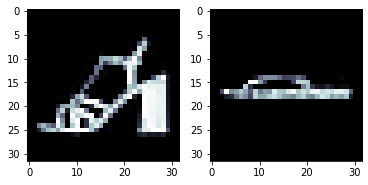

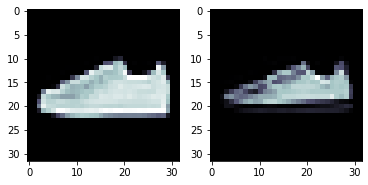

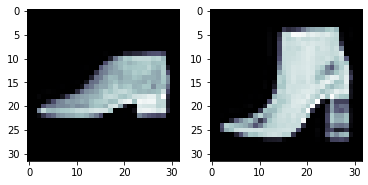

In [14]:
sandal_train_dataset, sandal_val_dataset, sandal_test_dataset = make_datasets(sandal_split)
sneaker_train_dataset, sneaker_val_dataset, sneaker_test_dataset = make_datasets(sneaker_split)
boot_train_dataset, boot_val_dataset, boot_test_dataset = make_datasets(boot_split)

show(sandal_train_dataset[0])
show(sneaker_train_dataset[0])
show(boot_train_dataset[0])

### omniglot

In [15]:
omniglot_path = omniglot_dir / 'omniglot-py' / 'images_background'
omniglot_data = defaultdict(dict)
for alphabet in omniglot._alphabets:
    omniglot_data[alphabet] = {
        character.name: list(character.glob('*.png'))
        for character in (omniglot_path / alphabet).iterdir()
    }

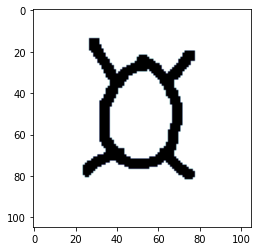

In [155]:
image_path = omniglot_data['Futurama']['character04'][1]
image = mpimg.imread(image_path)
plt.imshow(image)

In [17]:
class OmniglotDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        alphabet: dict,
        normalize: bool = True,
        padding: None | tuple[int, int] = (32, 32), 
        transforms: None | list[torchvision.transforms] = [
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(
                (32, 32), 
                interpolation=torchvision.transforms.InterpolationMode.NEAREST,
            ),
            torchvision.transforms.ToTensor(),
        ],
    ):
        self.alphabet = alphabet
        self.character_indexes = {k: list(range(len(v))) for k, v in self.alphabet.items()}
        self.index_map = dict()
        self.index_offset = dict()
        tmp = 0
        for char, indexes in self.character_indexes.items():
            self.index_offset[char] = tmp
            for i in indexes:
                self.index_map[tmp + i] = char
            tmp += len(indexes)
        self.len = sum(map(len, self.character_indexes.values()))
        self.normalize = normalize
        self.padding = padding
        self.transforms = torchvision.transforms.Compose(transforms)
        
    def shuffle(self):
        for index in self.character_indexes.values():
            np.random.shuffle(index)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        char = self.index_map[index]
        indexes = self.character_indexes[char]
        index -= self.index_offset[char] 
        index_1, index_2 = indexes[index], indexes[index-1]
        images = self.alphabet[char]
        path_1, path_2 = images[index_1], images[index_2]
        image_1 = 1 - mpimg.imread(path_1)
        image_2 = 1 - mpimg.imread(path_2)
        image_1, image_2 = self.transforms(image_1), self.transforms(image_2)
        return torch.cat([image_1, image_2], 0)

In [142]:
omniglot_data.keys()

dict_keys(['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh'])

4320


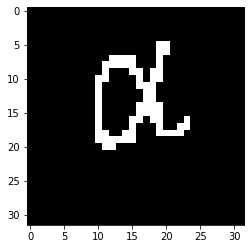

In [159]:
add_prefix = lambda lang, prefix: {f'{prefix}_{char}': path for char, path in lang.items()}
languages = [
    'Greek', 
    'Hebrew',
    'Latin',
    'Sanskrit',
    'Futurama',
    'Braille',
    'Cyrillic',
    'Tagalog',
]
omni_ds = OmniglotDataset({
    k: v for x in (add_prefix(omniglot_data[lang], lang) for lang in languages) 
    for k, v in x.items()
})
img = omni_ds[0]

print(len(omni_ds))
plt.imshow(img[0])

### select dataset

In [53]:
train_dataset = sneaker_train_dataset
val_dataset = sneaker_val_dataset
test_dataset = sneaker_test_dataset

### dataloaders

In [54]:
def get_dataloader(
    dataset: torch.utils.data.Dataset,
    batch_size: int=32,
    shuffle=True,
    pin_memory=True,
):
    return torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        pin_memory=pin_memory,
    )

In [160]:
sneaker_loader = get_dataloader(sneaker_train_dataset)
boot_loader = get_dataloader(boot_train_dataset)
val_loader = get_dataloader(val_dataset)
test_loader = get_dataloader(test_dataset, shuffle=False)
omni_loader = get_dataloader(omni_ds)

## build model

In [161]:
class Model(torch.nn.Module):
    def __init__(
        self,
        image_size: tuple[int, int] | tuple[int, int, int],
        input_channels: int = 2,
    ):
        super().__init__()
        self.image_size = image_size
        self.input_channels= input_channels
        self.ndim = len(image_size)
        self.unet = vm.networks.Unet(inshape=image_size, infeats=input_channels)
        self.flow = getattr(torch.nn, f'Conv{self.ndim}d')(16, 2, 3, padding=1)
        self.relu = torch.nn.LeakyReLU(0.2)
        self.spatial_transformer = vm.layers.SpatialTransformer(image_size)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        displacement = self.relu(self.flow(self.unet(x)))
        moving_image = x[:, 0].unsqueeze(1)
        moved_image = self.spatial_transformer(moving_image, displacement)
        return moved_image, displacement

In [162]:
inshape = (32, 32)
infeats = 2
base_model = Model((32, 32)).to('cuda')
domain_model = Model((32, 32)).to('cuda')

### loss function

In [163]:
mse = vm.losses.MSE()
grad = vm.losses.Grad('l2')

def loss_func(moving, fixed, displacement, weight=0.05):
    mse_loss = mse.loss(fixed, moving)
    grad_loss = grad.loss(displacement)
    return mse_loss + weight * grad_loss

## training

In [166]:
base_optimizer = torch.optim.Adam(base_model.parameters(), lr=3e-4)
domain_optimizer = torch.optim.Adam(domain_model.parameters(), lr=3e-4)

In [168]:
def iterate(
    model,
    optimizer,
    loader,
    training: bool = True,
):
    average_loss = 0.
    if training:
        model.train()
    else:
        model.eval()
    for i, images in tqdm(enumerate(loader)):
        moved_images, displacements = model(images.to('cuda'))
        fixed_images = images[:, 1].unsqueeze(1).to('cuda')
        loss = loss_func(moved_images, fixed_images, displacements)
        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        average_loss += loss.detach().item()
    return average_loss / len(loader)
    

def train(
    model,
    optimizer,
    train_loader,
    val_loader,
    train2_loader = None,
    epochs: int = 10,
):
    epoch_loss = defaultdict(list)
    for i in range(epochs):
        train_loss = iterate(model, optimizer, train_loader)
        epoch_loss['train'].append(train_loss)
        if train2_loader:
            train2_loss = iterate(model, optimizer, train2_loader)
            epoch_loss['train2'].append(train2_loss)
        val_loss = iterate(model, optimizer, val_loader, training=False)
        epoch_loss['val'].append(val_loss)
        print(f'epoch {i} finished')
    return epoch_loss

In [169]:
epoch_loss = train(base_model, base_optimizer, boot_loader, val_loader, train2_loader=sneaker_loader, epochs=100)

135it [00:01, 90.84it/s]
135it [00:01, 95.20it/s]
15it [00:00, 205.14it/s]


epoch 0 finished


135it [00:01, 88.69it/s]
135it [00:01, 97.56it/s]
15it [00:00, 181.94it/s]


epoch 1 finished


135it [00:01, 92.15it/s]
135it [00:01, 92.81it/s]
15it [00:00, 214.95it/s]


epoch 2 finished


135it [00:01, 93.50it/s]
135it [00:01, 86.37it/s]
15it [00:00, 189.03it/s]


epoch 3 finished


135it [00:01, 90.73it/s]
135it [00:01, 92.58it/s]
15it [00:00, 204.34it/s]


epoch 4 finished


135it [00:01, 86.19it/s]
135it [00:01, 93.18it/s]
15it [00:00, 212.03it/s]


epoch 5 finished


135it [00:01, 86.71it/s]
135it [00:01, 88.61it/s]
15it [00:00, 194.25it/s]


epoch 6 finished


135it [00:01, 86.71it/s]
135it [00:01, 83.61it/s]
15it [00:00, 157.73it/s]


epoch 7 finished


135it [00:01, 88.39it/s]
135it [00:01, 89.41it/s]
15it [00:00, 210.38it/s]


epoch 8 finished


135it [00:01, 89.70it/s]
135it [00:01, 92.43it/s]
15it [00:00, 203.21it/s]


epoch 9 finished


135it [00:01, 91.89it/s]
135it [00:01, 91.05it/s]
15it [00:00, 203.53it/s]


epoch 10 finished


135it [00:01, 88.08it/s]
135it [00:01, 92.09it/s]
15it [00:00, 210.76it/s]


epoch 11 finished


135it [00:01, 96.67it/s] 
135it [00:01, 90.04it/s]
15it [00:00, 182.34it/s]


epoch 12 finished


135it [00:01, 86.29it/s]
135it [00:01, 87.18it/s]
15it [00:00, 214.96it/s]


epoch 13 finished


135it [00:01, 96.96it/s]
135it [00:01, 97.82it/s] 
15it [00:00, 214.31it/s]


epoch 14 finished


135it [00:01, 100.75it/s]
135it [00:01, 100.88it/s]
15it [00:00, 214.88it/s]


epoch 15 finished


135it [00:01, 100.76it/s]
135it [00:01, 100.45it/s]
15it [00:00, 215.84it/s]


epoch 16 finished


135it [00:01, 100.66it/s]
135it [00:01, 95.55it/s]
15it [00:00, 201.46it/s]


epoch 17 finished


135it [00:01, 95.56it/s]
135it [00:01, 91.02it/s]
15it [00:00, 212.47it/s]


epoch 18 finished


135it [00:01, 84.65it/s]
135it [00:01, 91.99it/s]
15it [00:00, 181.91it/s]


epoch 19 finished


135it [00:01, 90.33it/s]
135it [00:01, 100.79it/s]
15it [00:00, 210.63it/s]


epoch 20 finished


135it [00:01, 92.26it/s]
135it [00:01, 92.70it/s]
15it [00:00, 182.19it/s]


epoch 21 finished


135it [00:01, 94.41it/s]
135it [00:01, 92.20it/s]
15it [00:00, 201.35it/s]


epoch 22 finished


135it [00:01, 96.55it/s]
135it [00:01, 93.43it/s]
15it [00:00, 202.63it/s]


epoch 23 finished


135it [00:01, 94.17it/s]
135it [00:01, 101.21it/s]
15it [00:00, 208.25it/s]


epoch 24 finished


135it [00:01, 92.48it/s]
135it [00:01, 95.67it/s]
15it [00:00, 195.65it/s]


epoch 25 finished


135it [00:01, 94.26it/s]
135it [00:01, 96.19it/s]
15it [00:00, 209.34it/s]


epoch 26 finished


135it [00:01, 96.65it/s]
135it [00:01, 93.45it/s]
15it [00:00, 172.65it/s]


epoch 27 finished


135it [00:01, 83.65it/s]
135it [00:01, 88.45it/s]
15it [00:00, 182.46it/s]


epoch 28 finished


135it [00:01, 89.07it/s]
135it [00:01, 88.98it/s]
15it [00:00, 183.18it/s]


epoch 29 finished


135it [00:01, 87.72it/s]
135it [00:01, 87.32it/s]
15it [00:00, 184.12it/s]


epoch 30 finished


135it [00:01, 89.43it/s]
135it [00:01, 92.77it/s]
15it [00:00, 156.53it/s]


epoch 31 finished


135it [00:01, 93.15it/s]
135it [00:01, 94.07it/s]
15it [00:00, 195.42it/s]


epoch 32 finished


135it [00:01, 99.51it/s]
135it [00:01, 99.58it/s]
15it [00:00, 213.65it/s]


epoch 33 finished


135it [00:01, 99.47it/s]
135it [00:01, 94.03it/s]
15it [00:00, 213.39it/s]


epoch 34 finished


135it [00:01, 99.76it/s]
135it [00:01, 98.90it/s]
15it [00:00, 214.12it/s]


epoch 35 finished


135it [00:01, 96.17it/s]
135it [00:01, 102.04it/s]
15it [00:00, 210.43it/s]


epoch 36 finished


135it [00:01, 103.32it/s]
135it [00:01, 99.85it/s]
15it [00:00, 209.44it/s]


epoch 37 finished


135it [00:01, 100.98it/s]
135it [00:01, 99.40it/s] 
15it [00:00, 216.13it/s]


epoch 38 finished


135it [00:01, 99.27it/s]
135it [00:01, 99.39it/s]
15it [00:00, 212.13it/s]


epoch 39 finished


135it [00:01, 99.75it/s] 
135it [00:01, 99.67it/s]
15it [00:00, 209.94it/s]


epoch 40 finished


135it [00:01, 99.80it/s] 
135it [00:01, 99.60it/s] 
15it [00:00, 215.56it/s]


epoch 41 finished


135it [00:01, 100.15it/s]
135it [00:01, 101.79it/s]
15it [00:00, 214.17it/s]


epoch 42 finished


135it [00:01, 104.00it/s]
135it [00:01, 97.82it/s]
15it [00:00, 216.31it/s]


epoch 43 finished


135it [00:01, 93.72it/s]
135it [00:01, 89.68it/s]
15it [00:00, 182.69it/s]


epoch 44 finished


135it [00:01, 92.19it/s]
135it [00:01, 87.51it/s]
15it [00:00, 182.30it/s]


epoch 45 finished


135it [00:01, 98.69it/s]
135it [00:01, 86.78it/s]
15it [00:00, 181.58it/s]


epoch 46 finished


135it [00:01, 89.05it/s]
135it [00:01, 84.70it/s]
15it [00:00, 164.10it/s]


epoch 47 finished


135it [00:01, 82.82it/s]
135it [00:01, 90.15it/s]
15it [00:00, 181.37it/s]


epoch 48 finished


135it [00:01, 88.87it/s]
135it [00:01, 89.51it/s]
15it [00:00, 182.73it/s]


epoch 49 finished


135it [00:01, 89.39it/s]
135it [00:01, 89.55it/s]
15it [00:00, 181.03it/s]


epoch 50 finished


135it [00:01, 87.99it/s]
135it [00:01, 87.35it/s]
15it [00:00, 178.89it/s]


epoch 51 finished


135it [00:01, 85.12it/s]
135it [00:01, 86.44it/s]
15it [00:00, 214.89it/s]


epoch 52 finished


135it [00:01, 94.23it/s]
135it [00:01, 94.43it/s]
15it [00:00, 211.38it/s]


epoch 53 finished


135it [00:01, 92.80it/s]
135it [00:01, 87.74it/s]
15it [00:00, 207.17it/s]


epoch 54 finished


135it [00:01, 88.84it/s]
135it [00:01, 90.29it/s]
15it [00:00, 214.54it/s]


epoch 55 finished


135it [00:01, 91.29it/s]
135it [00:01, 93.89it/s]
15it [00:00, 211.83it/s]


epoch 56 finished


135it [00:01, 89.39it/s]
135it [00:01, 88.37it/s]
15it [00:00, 182.45it/s]


epoch 57 finished


135it [00:01, 93.50it/s]
135it [00:01, 96.81it/s]
15it [00:00, 214.78it/s]


epoch 58 finished


135it [00:01, 96.06it/s]
135it [00:01, 93.39it/s]
15it [00:00, 214.68it/s]


epoch 59 finished


135it [00:01, 101.42it/s]
135it [00:01, 101.47it/s]
15it [00:00, 215.61it/s]


epoch 60 finished


135it [00:01, 95.37it/s]
135it [00:01, 91.47it/s]
15it [00:00, 197.09it/s]


epoch 61 finished


135it [00:01, 93.35it/s]
135it [00:01, 92.13it/s]
15it [00:00, 209.30it/s]


epoch 62 finished


135it [00:01, 95.24it/s]
135it [00:01, 97.69it/s]
15it [00:00, 212.52it/s]


epoch 63 finished


135it [00:01, 92.97it/s]
135it [00:01, 95.93it/s]
15it [00:00, 211.55it/s]


epoch 64 finished


135it [00:01, 92.83it/s]
135it [00:01, 90.64it/s]
15it [00:00, 182.34it/s]


epoch 65 finished


135it [00:01, 87.27it/s]
135it [00:01, 87.35it/s]
15it [00:00, 174.59it/s]


epoch 66 finished


135it [00:01, 87.27it/s]
135it [00:01, 87.91it/s]
15it [00:00, 182.02it/s]


epoch 67 finished


135it [00:01, 87.88it/s]
135it [00:01, 88.28it/s]
15it [00:00, 214.66it/s]


epoch 68 finished


135it [00:01, 96.76it/s]
135it [00:01, 98.97it/s] 
15it [00:00, 215.70it/s]


epoch 69 finished


135it [00:01, 97.69it/s]
135it [00:01, 96.48it/s]
15it [00:00, 215.42it/s]


epoch 70 finished


135it [00:01, 94.54it/s]
135it [00:01, 95.91it/s]
15it [00:00, 213.20it/s]


epoch 71 finished


135it [00:01, 96.40it/s]
135it [00:01, 95.61it/s]
15it [00:00, 179.42it/s]


epoch 72 finished


135it [00:01, 90.43it/s]
135it [00:01, 96.69it/s]
15it [00:00, 213.10it/s]


epoch 73 finished


135it [00:01, 96.68it/s]
135it [00:01, 95.34it/s]
15it [00:00, 215.81it/s]


epoch 74 finished


135it [00:01, 92.88it/s]
135it [00:01, 96.95it/s] 
15it [00:00, 214.27it/s]


epoch 75 finished


135it [00:01, 101.32it/s]
135it [00:01, 101.21it/s]
15it [00:00, 214.01it/s]


epoch 76 finished


135it [00:01, 99.30it/s] 
135it [00:01, 97.86it/s]
15it [00:00, 215.65it/s]


epoch 77 finished


135it [00:01, 92.98it/s]
135it [00:01, 97.35it/s]
15it [00:00, 212.57it/s]


epoch 78 finished


135it [00:01, 95.47it/s]
135it [00:01, 95.34it/s]
15it [00:00, 211.53it/s]


epoch 79 finished


135it [00:01, 93.12it/s]
135it [00:01, 95.88it/s] 
15it [00:00, 215.97it/s]


epoch 80 finished


135it [00:01, 100.18it/s]
135it [00:01, 99.26it/s] 
15it [00:00, 210.27it/s]


epoch 81 finished


135it [00:01, 97.78it/s]
135it [00:01, 95.78it/s]
15it [00:00, 213.99it/s]


epoch 82 finished


135it [00:01, 91.24it/s]
135it [00:01, 85.52it/s]
15it [00:00, 179.93it/s]


epoch 83 finished


135it [00:01, 85.84it/s]
135it [00:01, 83.96it/s]
15it [00:00, 163.85it/s]


epoch 84 finished


135it [00:01, 90.09it/s]
135it [00:01, 92.96it/s]
15it [00:00, 211.32it/s]


epoch 85 finished


135it [00:01, 98.86it/s]
135it [00:01, 90.97it/s]
15it [00:00, 206.45it/s]


epoch 86 finished


135it [00:01, 84.31it/s]
135it [00:01, 89.84it/s]
15it [00:00, 182.98it/s]


epoch 87 finished


135it [00:01, 94.09it/s]
135it [00:01, 96.89it/s]
15it [00:00, 207.17it/s]


epoch 88 finished


135it [00:01, 104.16it/s]
135it [00:01, 104.18it/s]
15it [00:00, 216.63it/s]


epoch 89 finished


135it [00:01, 103.96it/s]
135it [00:01, 104.12it/s]
15it [00:00, 216.22it/s]


epoch 90 finished


135it [00:01, 104.26it/s]
135it [00:01, 104.25it/s]
15it [00:00, 201.95it/s]


epoch 91 finished


135it [00:01, 102.50it/s]
135it [00:01, 92.15it/s]
15it [00:00, 210.31it/s]


epoch 92 finished


135it [00:01, 102.85it/s]
135it [00:01, 103.67it/s]
15it [00:00, 212.89it/s]


epoch 93 finished


135it [00:01, 103.50it/s]
135it [00:01, 103.38it/s]
15it [00:00, 212.87it/s]


epoch 94 finished


135it [00:01, 102.88it/s]
135it [00:01, 98.46it/s]
15it [00:00, 202.81it/s]


epoch 95 finished


135it [00:01, 102.30it/s]
135it [00:01, 103.66it/s]
15it [00:00, 210.96it/s]


epoch 96 finished


135it [00:01, 102.48it/s]
135it [00:01, 99.47it/s]
15it [00:00, 213.29it/s]


epoch 97 finished


135it [00:01, 98.41it/s]
135it [00:01, 89.99it/s]
15it [00:00, 182.78it/s]


epoch 98 finished


135it [00:01, 89.83it/s]
135it [00:01, 89.92it/s]
15it [00:00, 183.22it/s]

epoch 99 finished


In [170]:
domain_epoch_loss = train(domain_model, domain_optimizer, boot_loader, val_loader, train2_loader=omni_loader, epochs=100)

135it [00:01, 89.95it/s]
135it [01:06,  2.04it/s]
15it [00:00, 178.06it/s]


epoch 0 finished


135it [00:01, 88.39it/s]
135it [00:55,  2.45it/s]
15it [00:00, 181.69it/s]


epoch 1 finished


135it [00:01, 89.63it/s]
135it [00:56,  2.40it/s]
15it [00:00, 174.45it/s]


epoch 2 finished


135it [00:01, 95.00it/s]
135it [00:55,  2.45it/s]
15it [00:00, 182.63it/s]


epoch 3 finished


135it [00:01, 97.18it/s] 
135it [00:56,  2.41it/s]
15it [00:00, 182.90it/s]


epoch 4 finished


135it [00:01, 90.40it/s]
135it [00:55,  2.43it/s]
15it [00:00, 181.32it/s]


epoch 5 finished


135it [00:01, 95.24it/s]
135it [00:55,  2.43it/s]
15it [00:00, 182.44it/s]


epoch 6 finished


135it [00:01, 89.76it/s]
135it [00:56,  2.38it/s]
15it [00:00, 180.13it/s]


epoch 7 finished


135it [00:01, 96.55it/s]
135it [00:56,  2.40it/s]
15it [00:00, 181.16it/s]


epoch 8 finished


135it [00:01, 86.49it/s]
135it [00:55,  2.43it/s]
15it [00:00, 195.95it/s]


epoch 9 finished


135it [00:01, 92.99it/s]
135it [00:56,  2.39it/s]
15it [00:00, 181.68it/s]


epoch 10 finished


135it [00:01, 92.09it/s]
135it [00:56,  2.40it/s]
15it [00:00, 180.73it/s]


epoch 11 finished


135it [00:01, 89.14it/s]
135it [00:55,  2.41it/s]
15it [00:00, 184.55it/s]


epoch 12 finished


135it [00:01, 93.80it/s]
135it [00:56,  2.41it/s]
15it [00:00, 180.95it/s]


epoch 13 finished


135it [00:01, 85.03it/s]
135it [00:56,  2.39it/s]
15it [00:00, 199.78it/s]


epoch 14 finished


135it [00:01, 85.12it/s]
135it [00:56,  2.40it/s]
15it [00:00, 183.69it/s]


epoch 15 finished


135it [00:01, 86.09it/s]
135it [00:56,  2.37it/s]
15it [00:00, 184.56it/s]


epoch 16 finished


135it [00:01, 85.75it/s]
135it [00:56,  2.38it/s]
15it [00:00, 179.47it/s]


epoch 17 finished


135it [00:01, 89.73it/s]
135it [00:56,  2.39it/s]
15it [00:00, 178.76it/s]


epoch 18 finished


135it [00:01, 87.11it/s]
135it [00:56,  2.37it/s]
15it [00:00, 179.47it/s]


epoch 19 finished


135it [00:01, 87.90it/s]
135it [00:55,  2.43it/s]
15it [00:00, 184.62it/s]


epoch 20 finished


135it [00:01, 88.97it/s]
135it [00:56,  2.39it/s]
15it [00:00, 172.16it/s]


epoch 21 finished


135it [00:01, 83.19it/s]
135it [00:56,  2.39it/s]
15it [00:00, 205.98it/s]


epoch 22 finished


135it [00:01, 86.37it/s]
135it [00:56,  2.37it/s]
15it [00:00, 179.45it/s]


epoch 23 finished


135it [00:01, 89.36it/s]
135it [00:56,  2.38it/s]
15it [00:00, 181.06it/s]


epoch 24 finished


135it [00:01, 90.30it/s]
135it [00:56,  2.37it/s]
15it [00:00, 181.56it/s]


epoch 25 finished


135it [00:01, 78.93it/s]
135it [00:56,  2.38it/s]
15it [00:00, 180.66it/s]


epoch 26 finished


135it [00:01, 88.94it/s]
135it [00:56,  2.38it/s]
15it [00:00, 186.94it/s]


epoch 27 finished


135it [00:01, 85.06it/s]
135it [00:56,  2.38it/s]
15it [00:00, 180.15it/s]


epoch 28 finished


135it [00:01, 89.56it/s]
135it [00:56,  2.39it/s]
15it [00:00, 209.93it/s]


epoch 29 finished


135it [00:01, 98.61it/s]
135it [00:56,  2.37it/s]
15it [00:00, 179.28it/s]


epoch 30 finished


135it [00:01, 91.94it/s]
135it [00:55,  2.41it/s]
15it [00:00, 180.17it/s]


epoch 31 finished


135it [00:01, 91.72it/s]
135it [00:57,  2.37it/s]
15it [00:00, 179.87it/s]


epoch 32 finished


135it [00:01, 84.35it/s]
135it [00:56,  2.38it/s]
15it [00:00, 180.83it/s]


epoch 33 finished


135it [00:01, 83.75it/s]
135it [00:57,  2.37it/s]
15it [00:00, 198.05it/s]


epoch 34 finished


135it [00:01, 94.37it/s]
135it [00:56,  2.40it/s]
15it [00:00, 182.79it/s]


epoch 35 finished


135it [00:01, 90.30it/s]
135it [00:56,  2.38it/s]
15it [00:00, 179.28it/s]


epoch 36 finished


135it [00:01, 97.60it/s]
135it [00:57,  2.35it/s]
15it [00:00, 209.99it/s]


epoch 37 finished


135it [00:01, 91.07it/s]
135it [00:56,  2.39it/s]
15it [00:00, 174.20it/s]


epoch 38 finished


135it [00:01, 92.44it/s]
135it [00:55,  2.41it/s]
15it [00:00, 179.22it/s]


epoch 39 finished


135it [00:01, 90.21it/s]
135it [00:57,  2.35it/s]
15it [00:00, 175.05it/s]


epoch 40 finished


135it [00:01, 89.44it/s]
135it [00:59,  2.27it/s]
15it [00:00, 181.20it/s]


epoch 41 finished


135it [00:01, 85.72it/s]
135it [00:57,  2.33it/s]
15it [00:00, 180.68it/s]


epoch 42 finished


135it [00:01, 98.35it/s] 
135it [00:58,  2.30it/s]
15it [00:00, 182.93it/s]


epoch 43 finished


135it [00:01, 92.14it/s]
135it [00:57,  2.34it/s]
15it [00:00, 180.89it/s]


epoch 44 finished


135it [00:01, 86.23it/s]
135it [00:59,  2.26it/s]
15it [00:00, 213.20it/s]


epoch 45 finished


135it [00:01, 94.84it/s]
135it [00:58,  2.31it/s]
15it [00:00, 180.42it/s]


epoch 46 finished


135it [00:01, 89.39it/s]
135it [00:42,  3.21it/s]
15it [00:00, 181.52it/s]


epoch 47 finished


135it [00:01, 91.66it/s]
135it [00:29,  4.63it/s]
15it [00:00, 181.70it/s]


epoch 48 finished


135it [00:01, 90.98it/s]
135it [00:30,  4.47it/s]
15it [00:00, 209.28it/s]


epoch 49 finished


135it [00:01, 94.90it/s]
135it [00:41,  3.28it/s]
15it [00:00, 196.83it/s]


epoch 50 finished


135it [00:01, 96.47it/s]
135it [00:56,  2.37it/s]
15it [00:00, 184.98it/s]


epoch 51 finished


135it [00:01, 93.98it/s]
135it [00:56,  2.39it/s]
15it [00:00, 186.58it/s]


epoch 52 finished


135it [00:01, 94.51it/s]
135it [00:56,  2.37it/s]
15it [00:00, 181.29it/s]


epoch 53 finished


135it [00:01, 89.09it/s]
135it [00:55,  2.44it/s]
15it [00:00, 181.08it/s]


epoch 54 finished


135it [00:01, 86.39it/s]
135it [00:55,  2.43it/s]
15it [00:00, 181.04it/s]


epoch 55 finished


135it [00:01, 86.38it/s]
135it [00:56,  2.41it/s]
15it [00:00, 181.06it/s]


epoch 56 finished


135it [00:01, 86.43it/s]
135it [00:55,  2.42it/s]
15it [00:00, 181.27it/s]


epoch 57 finished


135it [00:01, 91.36it/s]
135it [00:57,  2.36it/s]
15it [00:00, 180.74it/s]


epoch 58 finished


135it [00:01, 86.52it/s]
135it [00:56,  2.40it/s]
15it [00:00, 181.48it/s]


epoch 59 finished


135it [00:01, 86.67it/s]
135it [00:56,  2.40it/s]
15it [00:00, 182.41it/s]


epoch 60 finished


135it [00:01, 86.61it/s]
135it [00:56,  2.40it/s]
15it [00:00, 182.07it/s]


epoch 61 finished


135it [00:01, 86.68it/s]
135it [00:56,  2.37it/s]
15it [00:00, 182.69it/s]


epoch 62 finished


135it [00:01, 90.35it/s]
135it [00:56,  2.40it/s]
15it [00:00, 181.45it/s]


epoch 63 finished


135it [00:01, 90.28it/s]
135it [00:56,  2.40it/s]
15it [00:00, 183.80it/s]


epoch 64 finished


135it [00:01, 90.56it/s]
135it [00:56,  2.40it/s]
15it [00:00, 181.09it/s]


epoch 65 finished


135it [00:01, 90.30it/s]
135it [00:56,  2.38it/s]
15it [00:00, 183.87it/s]


epoch 66 finished


135it [00:01, 93.14it/s]
135it [00:56,  2.40it/s]
15it [00:00, 181.70it/s]


epoch 67 finished


135it [00:01, 92.05it/s]
135it [00:56,  2.41it/s]
15it [00:00, 181.39it/s]


epoch 68 finished


135it [00:01, 89.97it/s]
135it [00:56,  2.40it/s]
15it [00:00, 180.62it/s]


epoch 69 finished


135it [00:01, 89.81it/s]
135it [00:56,  2.39it/s]
15it [00:00, 180.98it/s]


epoch 70 finished


135it [00:01, 90.14it/s]
135it [00:56,  2.39it/s]
15it [00:00, 198.68it/s]


epoch 71 finished


135it [00:01, 89.94it/s]
135it [00:56,  2.40it/s]
15it [00:00, 181.35it/s]


epoch 72 finished


135it [00:01, 88.54it/s]
135it [00:55,  2.42it/s]
15it [00:00, 181.24it/s]


epoch 73 finished


135it [00:01, 91.00it/s]
135it [00:56,  2.41it/s]
15it [00:00, 180.31it/s]


epoch 74 finished


135it [00:01, 86.23it/s]
135it [00:56,  2.37it/s]
15it [00:00, 180.33it/s]


epoch 75 finished


135it [00:01, 87.59it/s]
135it [00:56,  2.39it/s]
15it [00:00, 180.85it/s]


epoch 76 finished


135it [00:01, 90.04it/s]
135it [00:56,  2.39it/s]
15it [00:00, 180.77it/s]


epoch 77 finished


135it [00:01, 90.08it/s]
135it [00:56,  2.37it/s]
15it [00:00, 208.65it/s]


epoch 78 finished


135it [00:01, 92.98it/s]
135it [00:57,  2.36it/s]
15it [00:00, 201.96it/s]


epoch 79 finished


135it [00:01, 85.31it/s]
135it [00:58,  2.33it/s]
15it [00:00, 176.15it/s]


epoch 80 finished


135it [00:01, 87.33it/s]
135it [00:57,  2.36it/s]
15it [00:00, 181.45it/s]


epoch 81 finished


135it [00:01, 88.58it/s]
135it [00:57,  2.34it/s]
15it [00:00, 182.00it/s]


epoch 82 finished


135it [00:01, 89.95it/s]
135it [00:58,  2.31it/s]
15it [00:00, 181.63it/s]


epoch 83 finished


135it [00:01, 93.59it/s]
135it [00:57,  2.36it/s]
15it [00:00, 182.20it/s]


epoch 84 finished


135it [00:01, 89.24it/s]
135it [00:57,  2.35it/s]
15it [00:00, 167.16it/s]


epoch 85 finished


135it [00:01, 90.11it/s]
135it [00:57,  2.36it/s]
15it [00:00, 182.78it/s]


epoch 86 finished


135it [00:01, 88.41it/s]
135it [00:57,  2.36it/s]
15it [00:00, 180.48it/s]


epoch 87 finished


135it [00:01, 92.33it/s]
135it [00:57,  2.36it/s]
15it [00:00, 182.24it/s]


epoch 88 finished


135it [00:01, 90.17it/s]
135it [00:59,  2.28it/s]
15it [00:00, 203.05it/s]


epoch 89 finished


135it [00:01, 80.37it/s]
135it [00:57,  2.34it/s]
15it [00:00, 170.87it/s]


epoch 90 finished


135it [00:01, 83.20it/s]
135it [00:59,  2.26it/s]
15it [00:00, 198.89it/s]


epoch 91 finished


135it [00:01, 90.71it/s]
135it [00:57,  2.33it/s]
15it [00:00, 202.24it/s]


epoch 92 finished


135it [00:01, 94.15it/s]
135it [01:02,  2.16it/s]
15it [00:00, 182.57it/s]


epoch 93 finished


135it [00:01, 101.92it/s]
135it [00:58,  2.30it/s]
15it [00:00, 171.54it/s]


epoch 94 finished


135it [00:01, 75.59it/s]
135it [01:01,  2.18it/s]
15it [00:00, 183.07it/s]


epoch 95 finished


135it [00:01, 86.88it/s]
135it [01:00,  2.25it/s]
15it [00:00, 174.71it/s]


epoch 96 finished


135it [00:01, 88.95it/s]
135it [00:59,  2.28it/s]
15it [00:00, 199.38it/s]


epoch 97 finished


135it [00:01, 94.91it/s]
135it [01:02,  2.17it/s]
15it [00:00, 177.87it/s]


epoch 98 finished


135it [00:01, 80.27it/s]
135it [01:00,  2.23it/s]
15it [00:00, 207.46it/s]

epoch 99 finished


In [192]:
epoch_loss['val'][-1], domain_epoch_loss['val'][-1]

(0.009545245083669822, 0.011741229519248008)

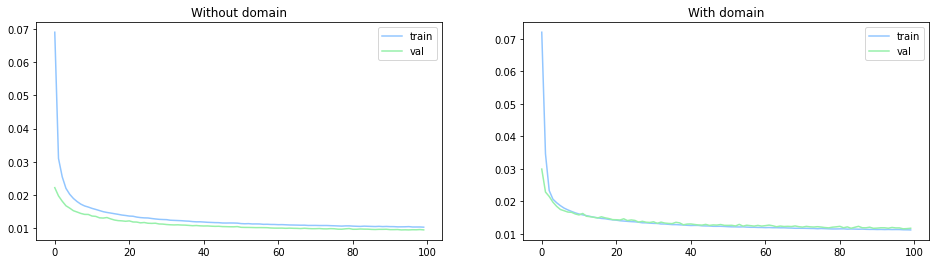

In [173]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 4))
ax[0].set_title('Without domain')
ax[0].plot(epoch_loss['train'], label='train')
ax[0].plot(epoch_loss['val'], label='val')
ax[0].legend()
ax[1].set_title('With domain')
ax[1].plot(domain_epoch_loss['train'], label='train')
ax[1].plot(domain_epoch_loss['val'], label='val')
ax[1].legend()

## experiments

In [189]:
test_dataset = zero_test_dataset
for k, test_dataset in {
    'zero': zero_test_dataset,
    'one': one_test_dataset,
    'two': two_test_dataset,
    'three': three_test_dataset,
    'four': four_test_dataset,
    'five': five_test_dataset,
    'six': six_test_dataset,
    'seven': seven_test_dataset,
    'eight': eight_test_dataset,
    'nine': nine_test_dataset,
}.items():
    test_loader = get_dataloader(test_dataset, shuffle=False, batch_size=1)
    n = len(test_loader)
    
    base_error = 0
    base_model.eval()
    domain_error = 0
    domain_model.eval()
    for i, batch in enumerate(test_loader):
        base_moved, base_warp = base_model(batch.cuda())
        base_moved = base_moved.detach().cpu().numpy()
        base_warp = base_warp.detach().cpu().numpy()
        base_error += mse.loss(batch[:, 0], base_moved[:, 0]).item()
        
        domain_moved, domain_warp = domain_model(batch.cuda())
        domain_moved = domain_moved.detach().cpu().numpy()
        domain_warp = domain_warp.detach().cpu().numpy()
        domain_error += mse.loss(batch[:, 0], domain_moved[:, 0]).item()
        
        if i > 32: continue 
        fontsize=24
        cmap=plt.cm.bone
        moving, fixed = batch[0, 0], batch[0, 1]
        fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
        ax[0, 0].imshow(fixed, cmap=cmap)
        ax[0, 0].set_title(r'fixed', fontsize=fontsize)
        ax[0, 1].imshow(moving, cmap=cmap)
        ax[0, 1].set_title(r'moving', fontsize=fontsize)
        ax[0, 2].imshow(base_moved[0, 0], cmap=cmap)
        ax[0, 2].set_title(r'moved (baseline)', fontsize=fontsize)
        base_flow = ax[0, 3].imshow(base_warp[0].sum(0), cmap=cmap)
        ax[0, 3].set_title(r'flow (baseline)', fontsize=fontsize)
        # plt.colorbar(base_flow, ax=ax[0, 3])
        ax[1, 0].imshow(fixed, cmap=cmap)
        ax[1, 0].set_title(r'fixed', fontsize=fontsize)
        ax[1, 1].imshow(moving, cmap=cmap)
        ax[1, 1].set_title(r'moving', fontsize=fontsize)
        ax[1, 2].imshow(domain_moved[0, 0], cmap=cmap)
        ax[1, 2].set_title(r'moved (domain)', fontsize=fontsize)
        domain_flow = ax[1, 3].imshow(domain_warp[0].sum(0), cmap=cmap)
        ax[1, 3].set_title(r'flow (domain)', fontsize=fontsize)
        # plt.colorbar(domain_flow, ax=ax[0, 3])
        plt.savefig(f'figures/voxelmorph-domain-{k}-{str(i).zfill(4)}.png')
        plt.close()
        # plt.show()
        
    print(k, base_error/n, domain_error/n)

zero 0.09161651124265296 0.09183266730916158
one 0.041249093285028196 0.04120022796648233
two 0.08696581656621545 0.08892308077192376
three 0.07475457413008019 0.07685049612455222
four 0.0680084732132098 0.07045907758003948
five 0.08214271254321545 0.08363088615245547
six 0.07459308739219393 0.07118452867746529
seven 0.06618250284742672 0.06726436163953389
eight 0.0764234982179183 0.07658318218426943
nine 0.06548852276580237 0.06625567970028236


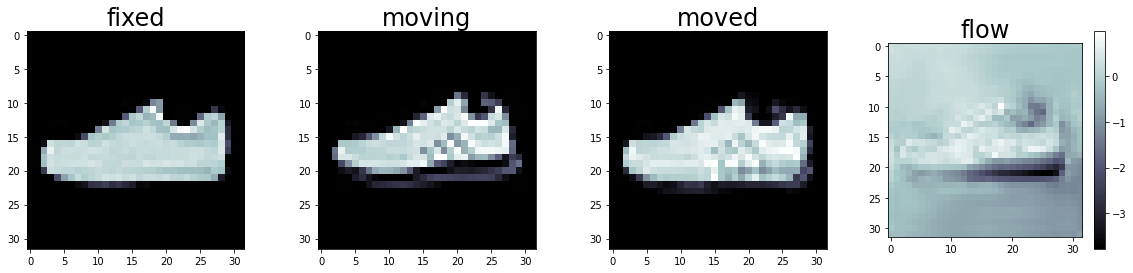

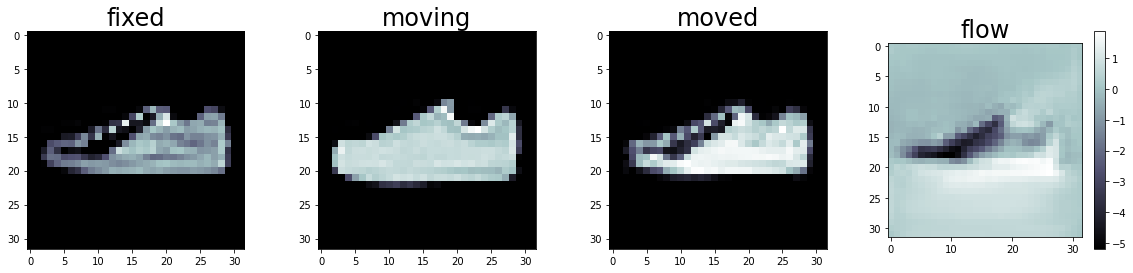

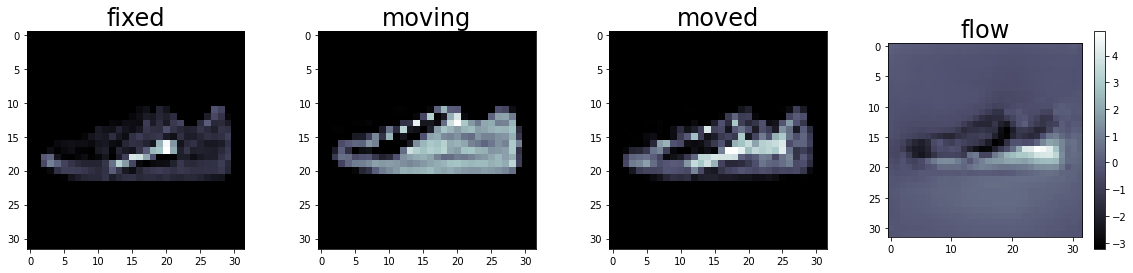

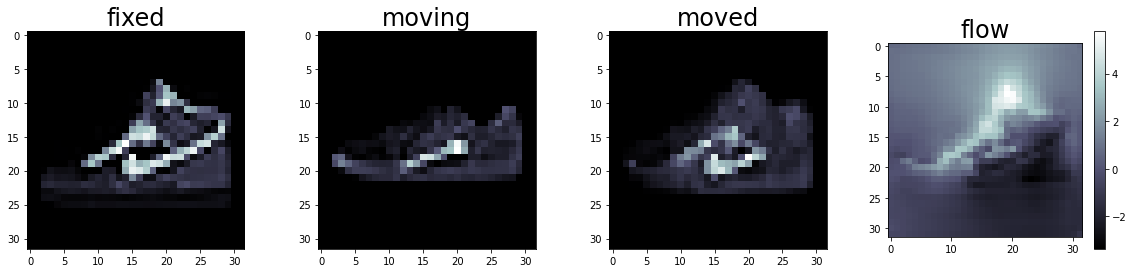

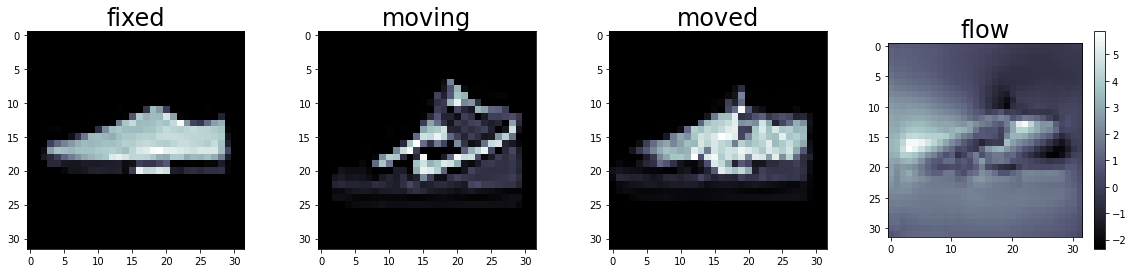

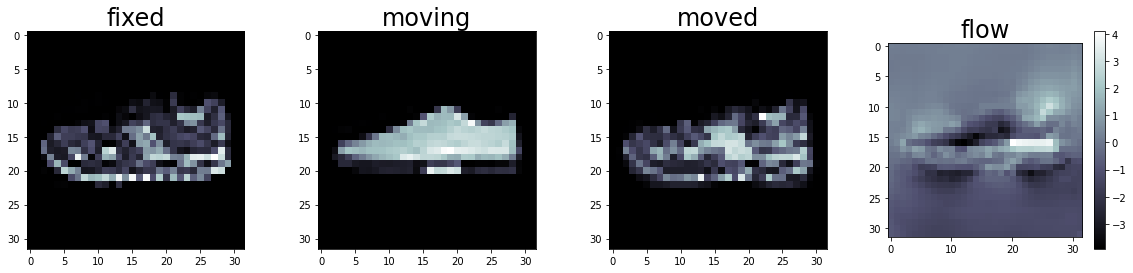

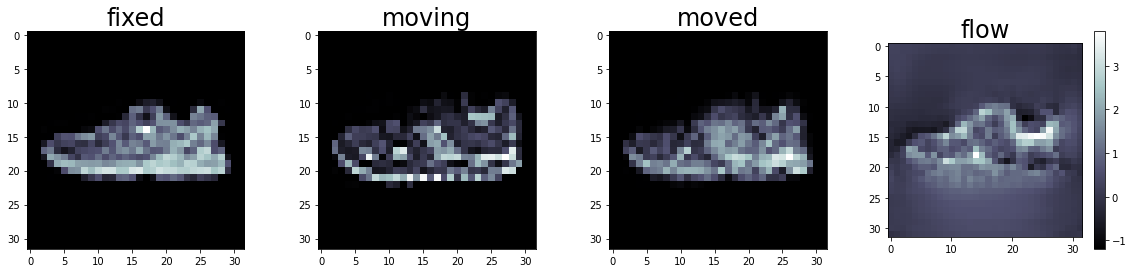

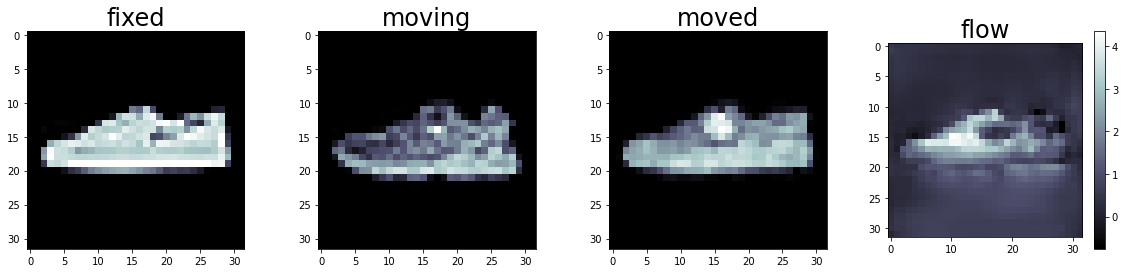

In [100]:
for k in range(8):
    fontsize=24
    cmap=plt.cm.bone
    moving, fixed = test_images[k, 0], test_images[k, 1]
    fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
    ax[0].imshow(fixed, cmap=cmap)
    ax[0].set_title(r'fixed', fontsize=fontsize)
    ax[1].imshow(moving, cmap=cmap)
    ax[1].set_title(r'moving', fontsize=fontsize)
    ax[2].imshow(moved[k, 0], cmap=cmap)
    ax[2].set_title(r'moved', fontsize=fontsize)
    flow = ax[3].imshow(warp[k].sum(0), cmap=cmap)
    ax[3].set_title(r'flow', fontsize=fontsize)
    plt.colorbar(flow, ax=ax[3])
    # plt.savefig(f'figures/voxelmorph-sneaker-example-{k}.png')
    plt.show()

### test on out-of-distribution examples

In [101]:
test_dataset = zero_test_dataset
test_loader = get_dataloader(test_dataset, shuffle=False)

In [102]:
test_images = next(iter(test_loader)).to('cuda')
moved, warp = domain_model(test_images)
test_images = test_images.cpu().detach().numpy()
moved = moved.cpu().detach().numpy()
warp = warp.cpu().detach().numpy()

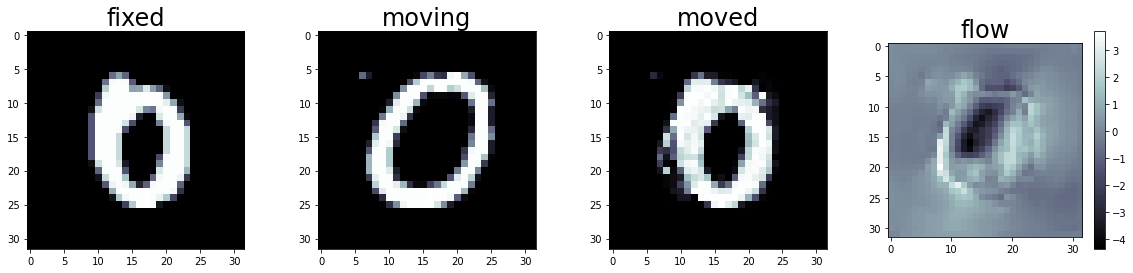

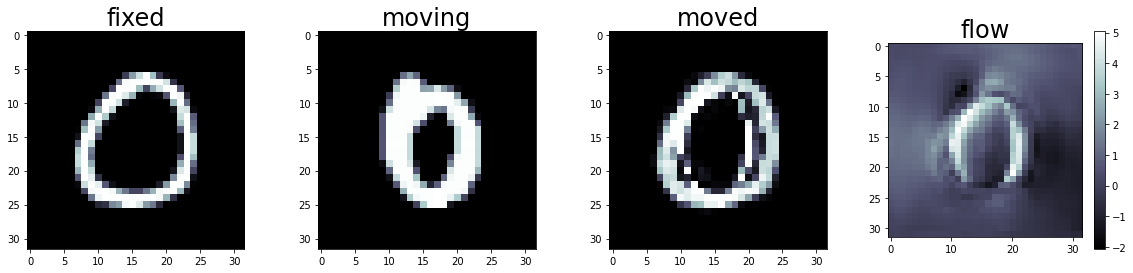

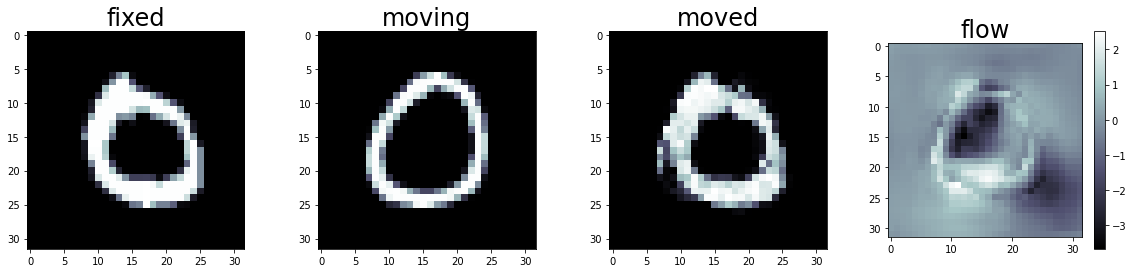

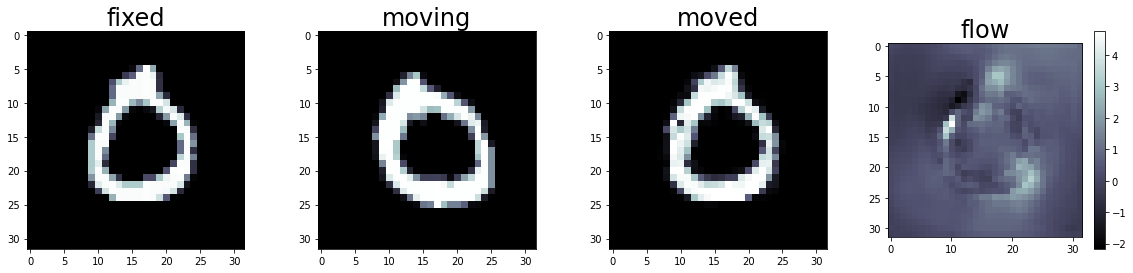

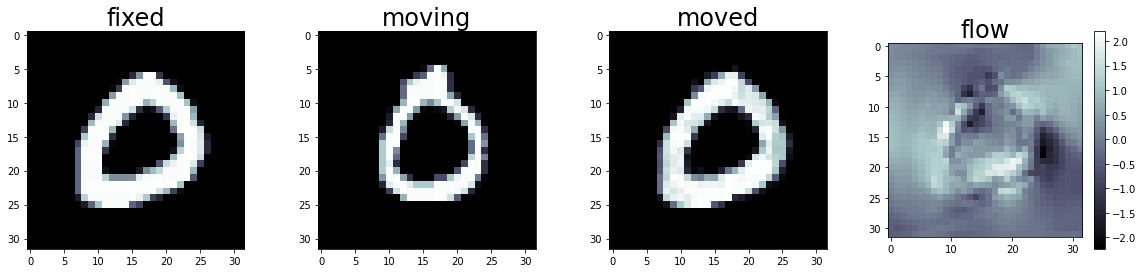

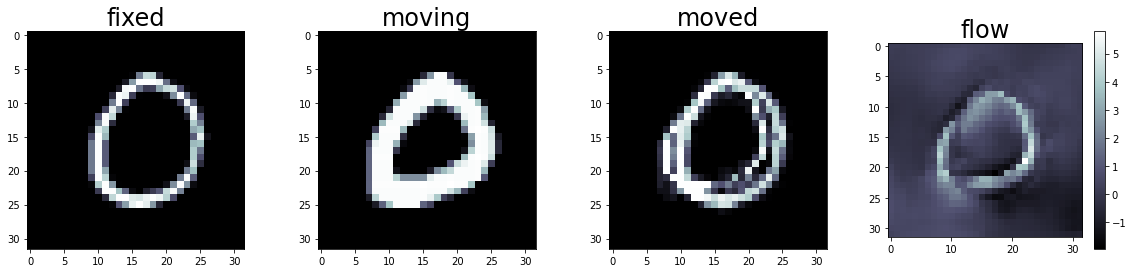

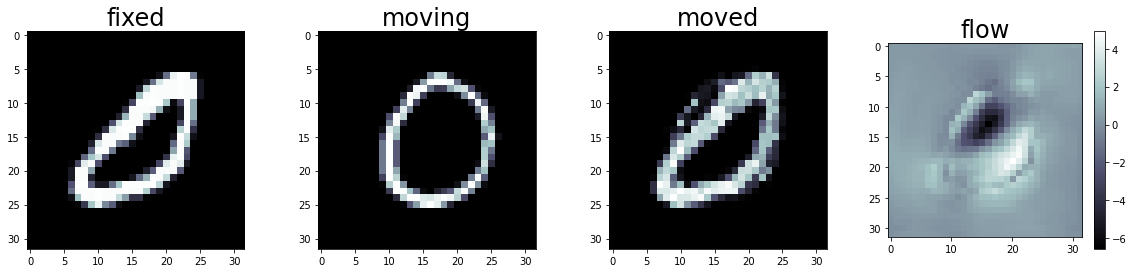

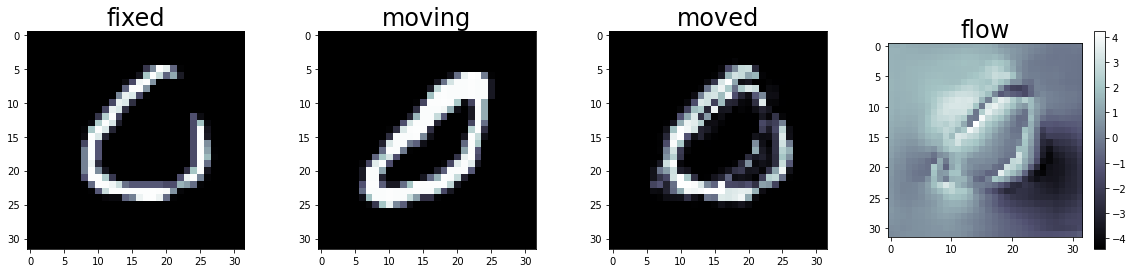

In [103]:
for k in range(8):
    fontsize=24
    cmap=plt.cm.bone
    moving, fixed = test_images[k, 0], test_images[k, 1]
    fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
    ax[0].imshow(fixed, cmap=cmap)
    ax[0].set_title(r'fixed', fontsize=fontsize)
    ax[1].imshow(moving, cmap=cmap)
    ax[1].set_title(r'moving', fontsize=fontsize)
    ax[2].imshow(moved[k, 0], cmap=cmap)
    ax[2].set_title(r'moved', fontsize=fontsize)
    flow = ax[3].imshow(warp[k].sum(0), cmap=cmap)
    ax[3].set_title(r'flow', fontsize=fontsize)
    plt.colorbar(flow, ax=ax[3])
    # plt.savefig(f'figures/voxelmorph-sandal-example-{k}.png')
    plt.show()

In [104]:
test_dataset = boot_test_dataset
test_loader = get_dataloader(test_dataset, shuffle=False)

In [105]:
test_images = next(iter(test_loader)).to('cuda')
moved, warp = domain_model(test_images)
test_images = test_images.cpu().detach().numpy()
moved = moved.cpu().detach().numpy()
warp = warp.cpu().detach().numpy()

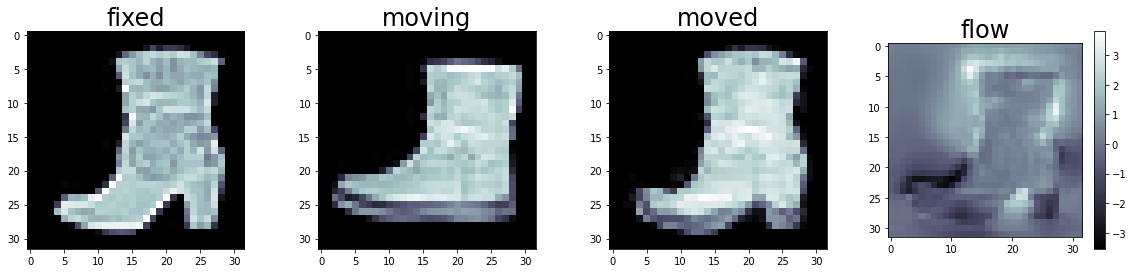

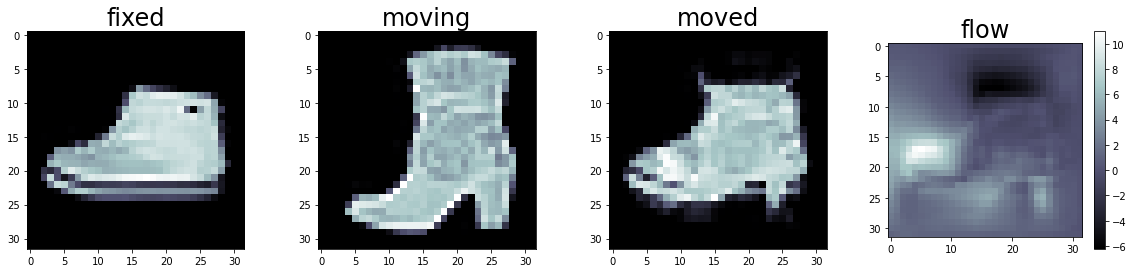

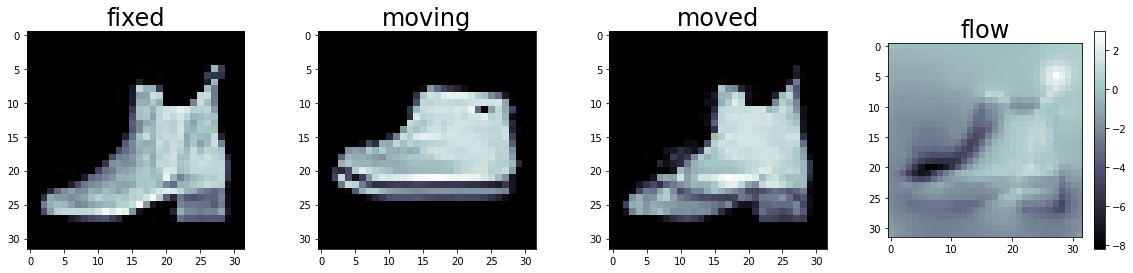

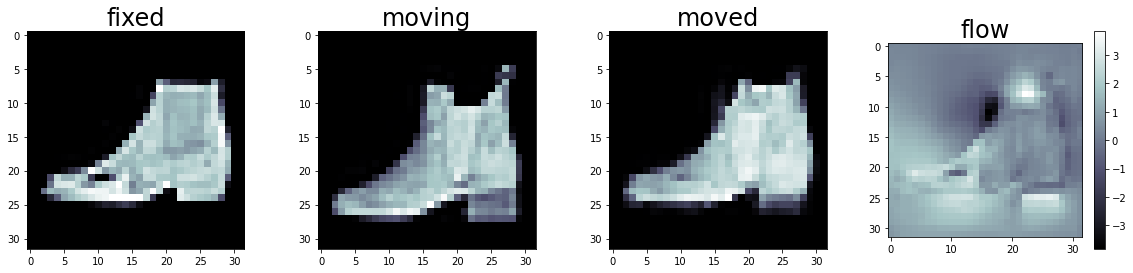

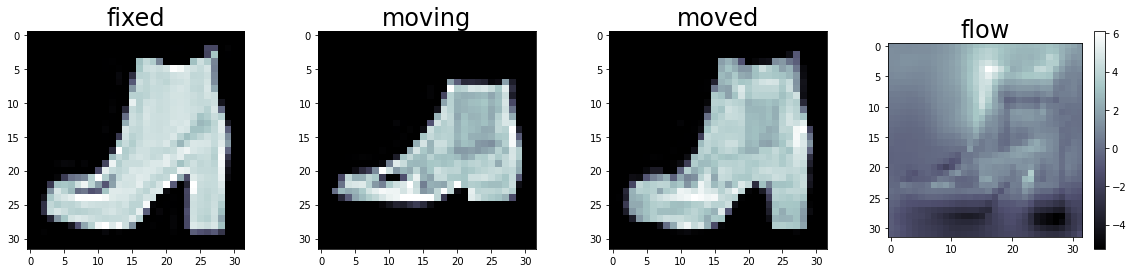

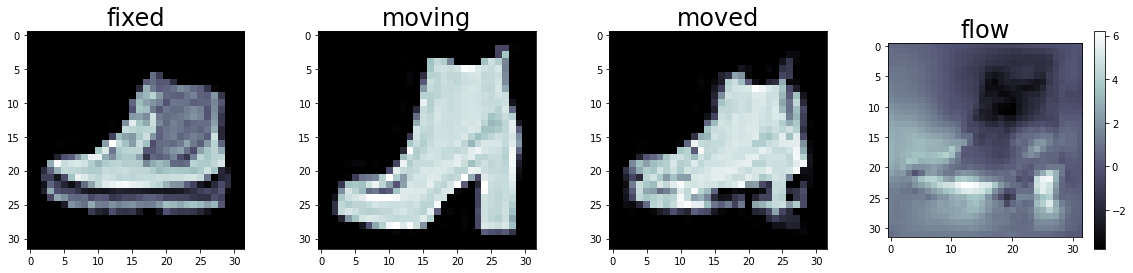

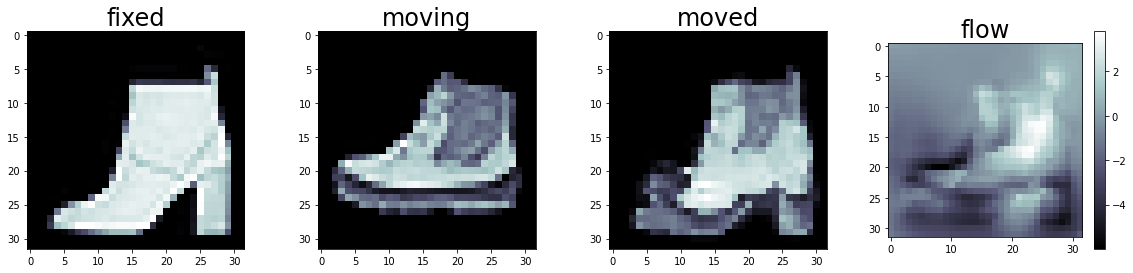

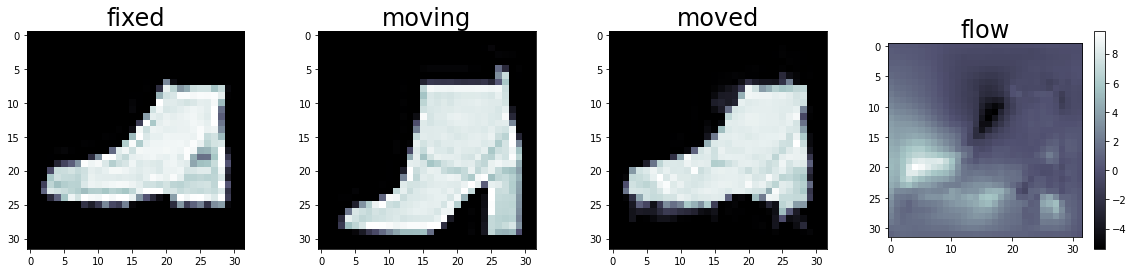

In [106]:
for k in range(8):
    fontsize=24
    cmap=plt.cm.bone
    moving, fixed = test_images[k, 0], test_images[k, 1]
    fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
    ax[0].imshow(fixed, cmap=cmap)
    ax[0].set_title(r'fixed', fontsize=fontsize)
    ax[1].imshow(moving, cmap=cmap)
    ax[1].set_title(r'moving', fontsize=fontsize)
    ax[2].imshow(moved[k, 0], cmap=cmap)
    ax[2].set_title(r'moved', fontsize=fontsize)
    flow = ax[3].imshow(warp[k].sum(0), cmap=cmap)
    ax[3].set_title(r'flow', fontsize=fontsize)
    plt.colorbar(flow, ax=ax[3])
    # plt.savefig(f'figures/voxelmorph-boot-example-{k}.png')
    plt.show()

In [88]:
test_dataset = zero_test_dataset
test_loader = get_dataloader(test_dataset, shuffle=False)

In [89]:
test_images = next(iter(test_loader)).to('cuda')
moved, warp = model(test_images)
test_images = test_images.cpu().detach().numpy()
moved = moved.cpu().detach().numpy()
warp = warp.cpu().detach().numpy()

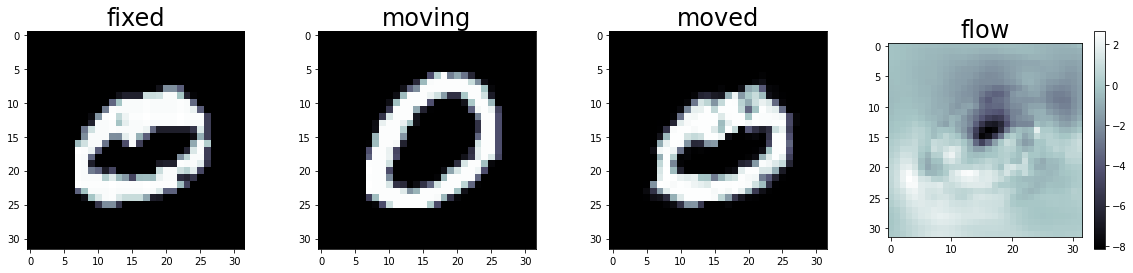

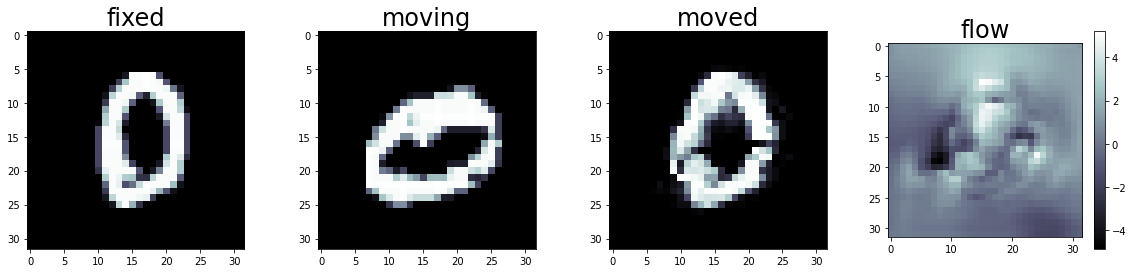

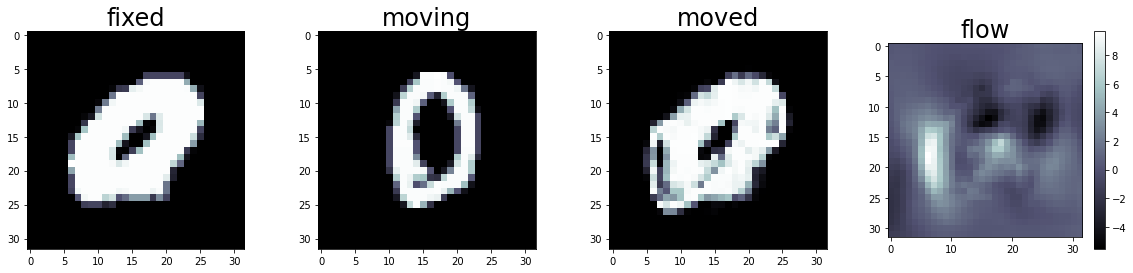

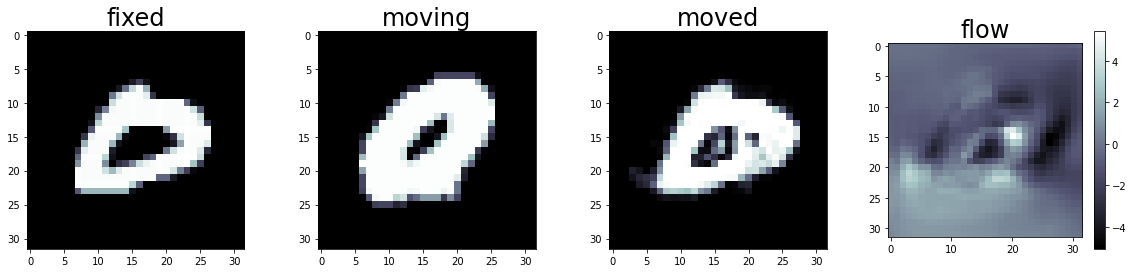

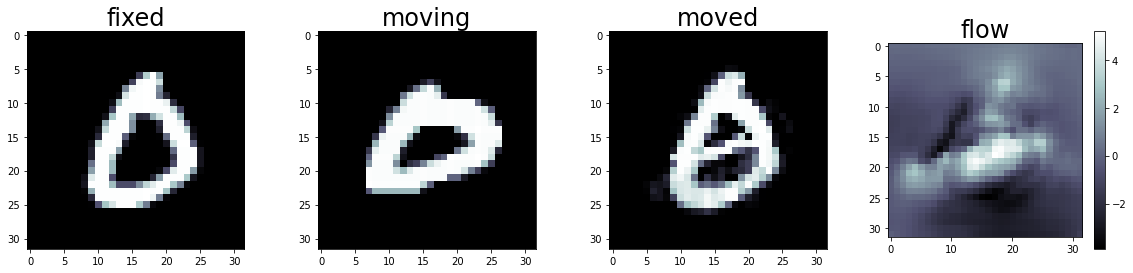

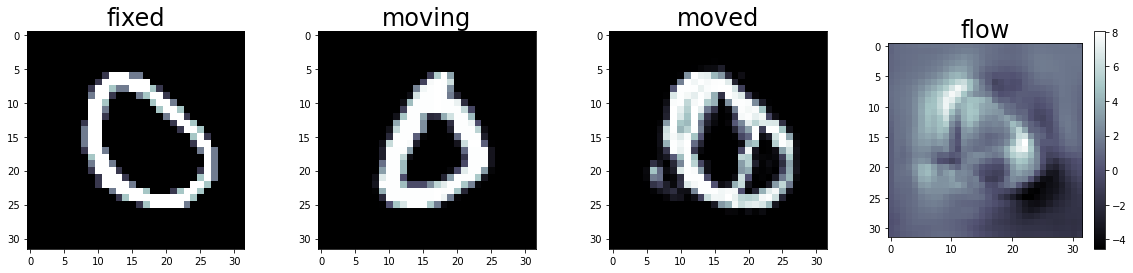

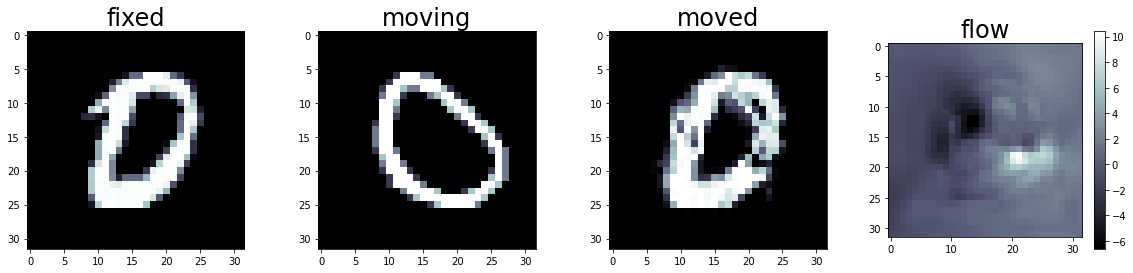

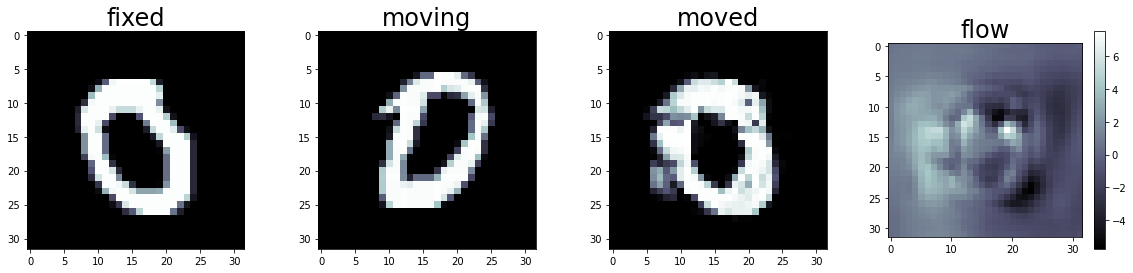

In [90]:
for k in range(8):
    fontsize=24
    cmap=plt.cm.bone
    moving, fixed = test_images[k, 0], test_images[k, 1]
    fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
    ax[0].imshow(fixed, cmap=cmap)
    ax[0].set_title(r'fixed', fontsize=fontsize)
    ax[1].imshow(moving, cmap=cmap)
    ax[1].set_title(r'moving', fontsize=fontsize)
    ax[2].imshow(moved[k, 0], cmap=cmap)
    ax[2].set_title(r'moved', fontsize=fontsize)
    flow = ax[3].imshow(warp[k].sum(0), cmap=cmap)
    ax[3].set_title(r'flow', fontsize=fontsize)
    plt.colorbar(flow, ax=ax[3])
    plt.savefig(f'figures/voxelmorph-zero-example-{k}.png')
    plt.show()

In [79]:
test_dataset = three_test_dataset
test_loader = get_dataloader(test_dataset, shuffle=False)

In [80]:
test_images = next(iter(test_loader)).to('cuda')
moved, warp = model(test_images)
test_images = test_images.cpu().detach().numpy()
moved = moved.cpu().detach().numpy()
warp = warp.cpu().detach().numpy()

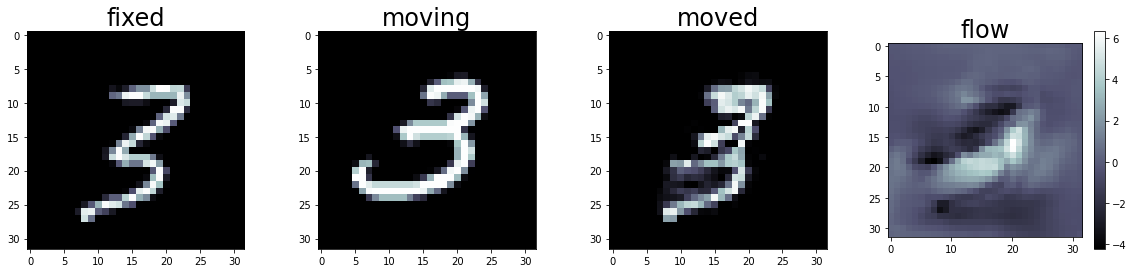

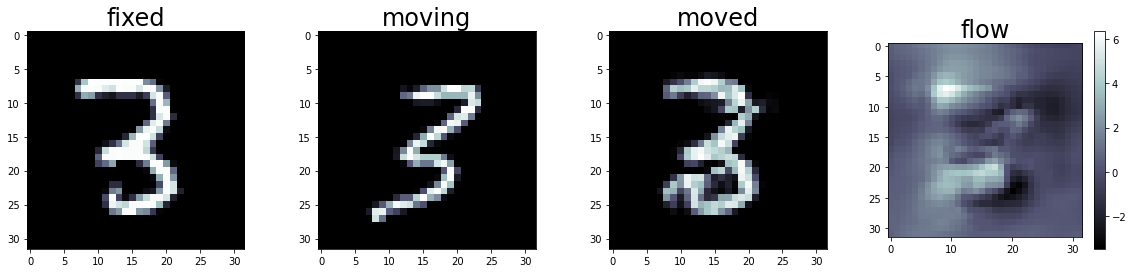

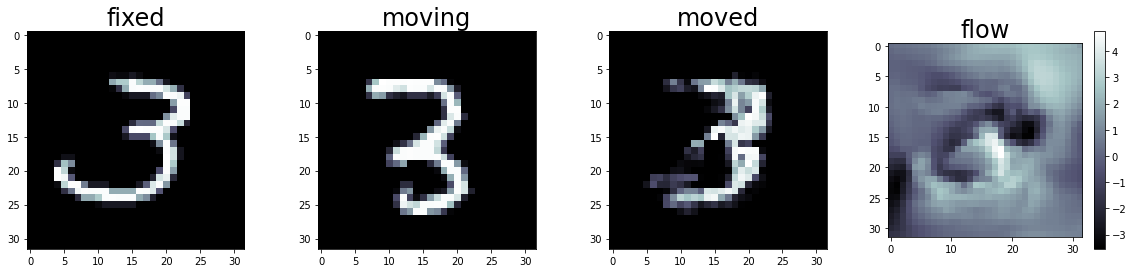

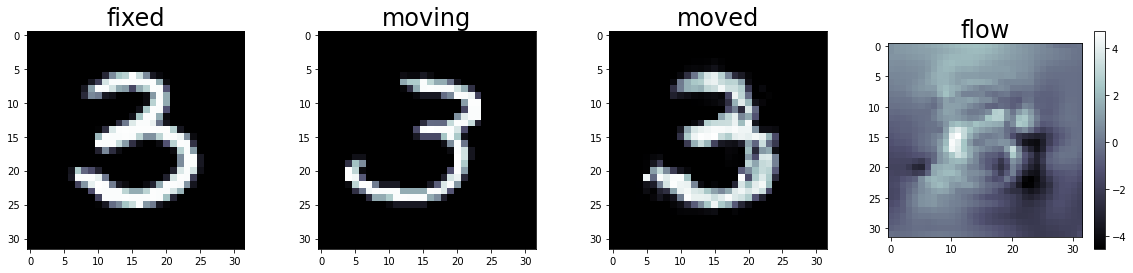

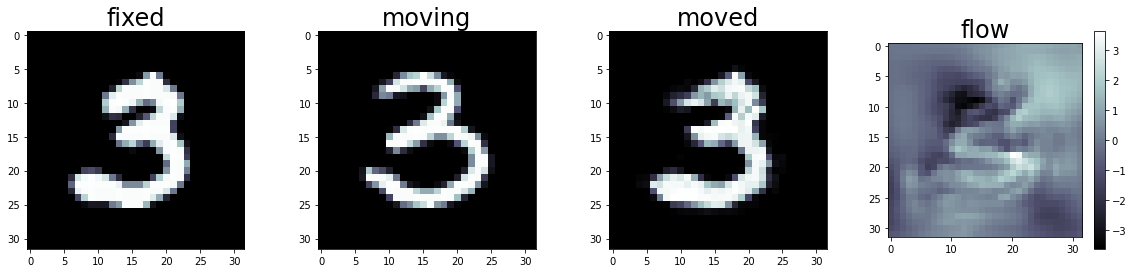

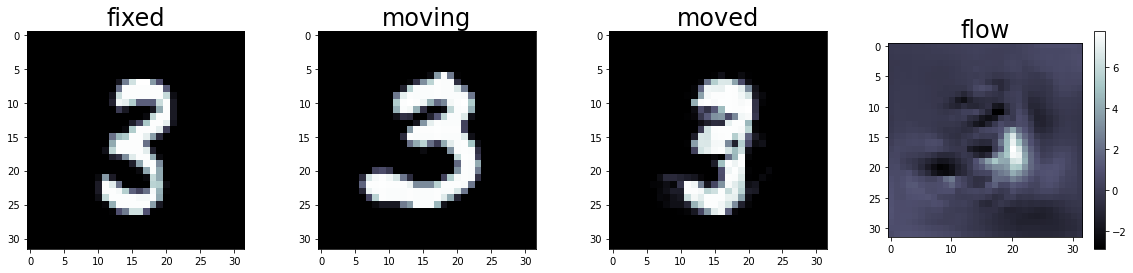

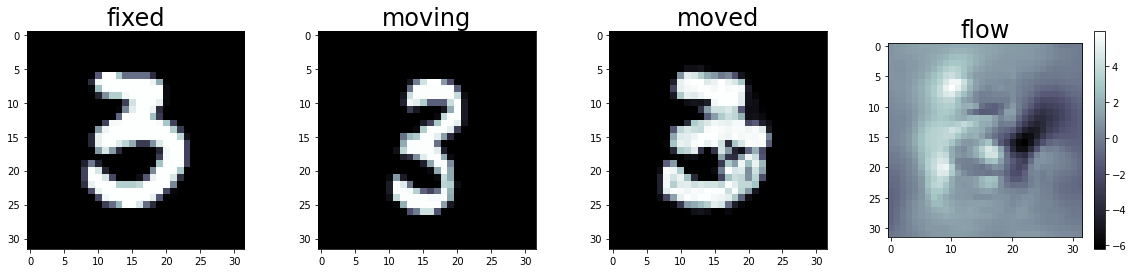

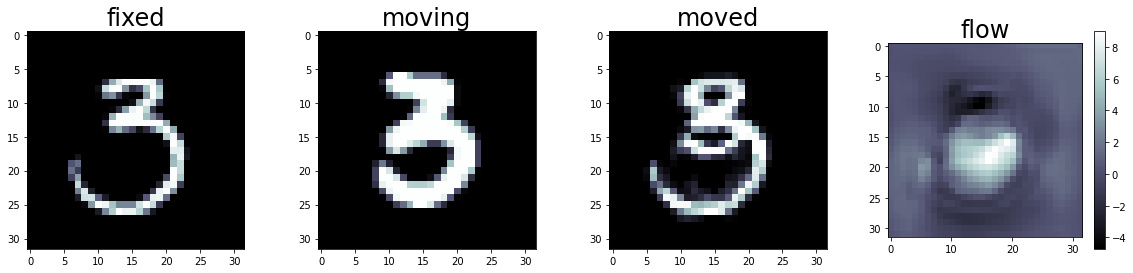

In [81]:
for k in range(8):
    fontsize=24
    cmap=plt.cm.bone
    moving, fixed = test_images[k, 0], test_images[k, 1]
    fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
    ax[0].imshow(fixed, cmap=cmap)
    ax[0].set_title(r'fixed', fontsize=fontsize)
    ax[1].imshow(moving, cmap=cmap)
    ax[1].set_title(r'moving', fontsize=fontsize)
    ax[2].imshow(moved[k, 0], cmap=cmap)
    ax[2].set_title(r'moved', fontsize=fontsize)
    flow = ax[3].imshow(warp[k].sum(0), cmap=cmap)
    ax[3].set_title(r'flow', fontsize=fontsize)
    plt.colorbar(flow, ax=ax[3])
    plt.savefig(f'figures/voxelmorph-three-example-{k}.png')
    plt.show()

In [85]:
test_dataset = five_test_dataset
test_loader = get_dataloader(test_dataset, shuffle=False)

In [86]:
test_images = next(iter(test_loader)).to('cuda')
moved, warp = model(test_images)
test_images = test_images.cpu().detach().numpy()
moved = moved.cpu().detach().numpy()
warp = warp.cpu().detach().numpy()

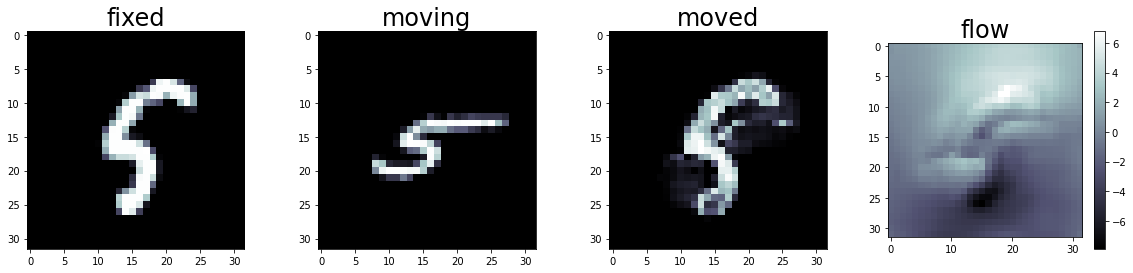

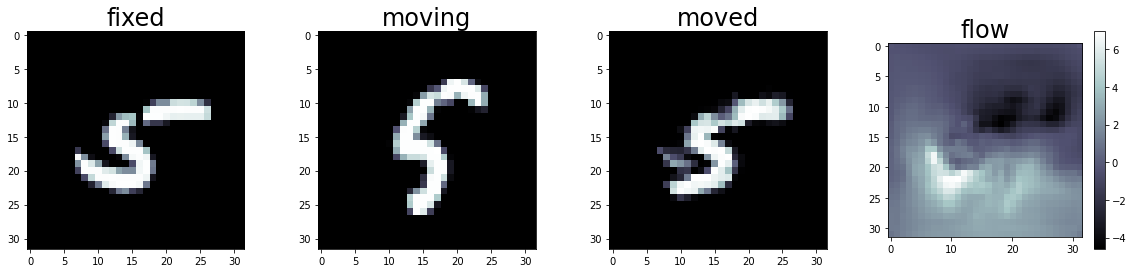

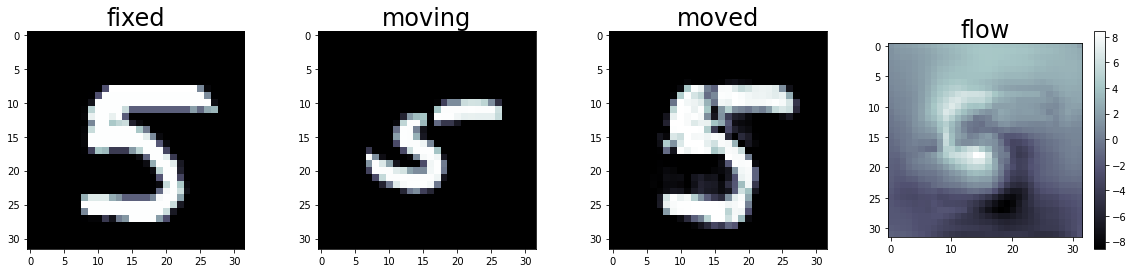

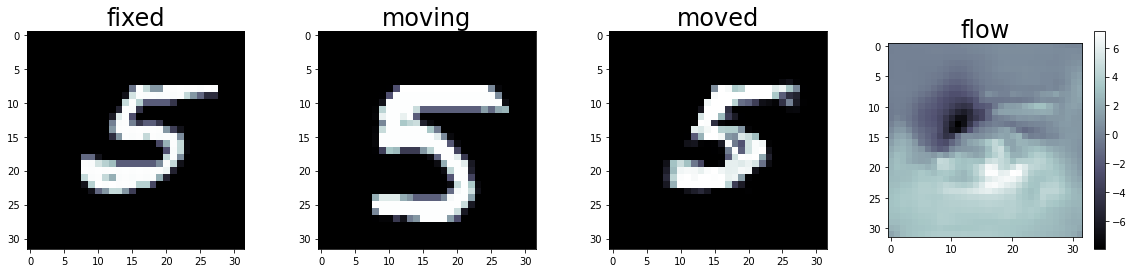

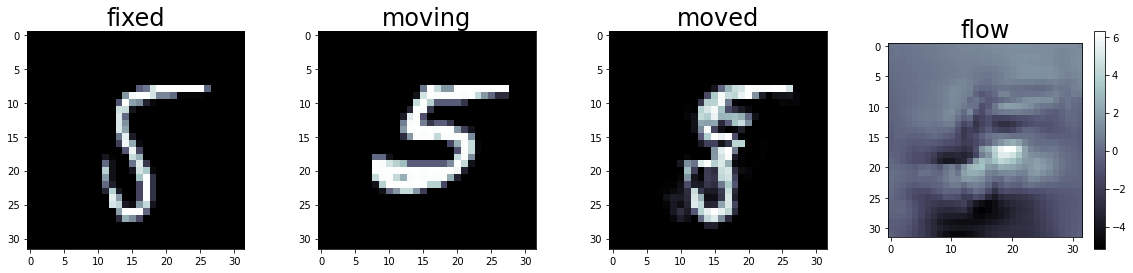

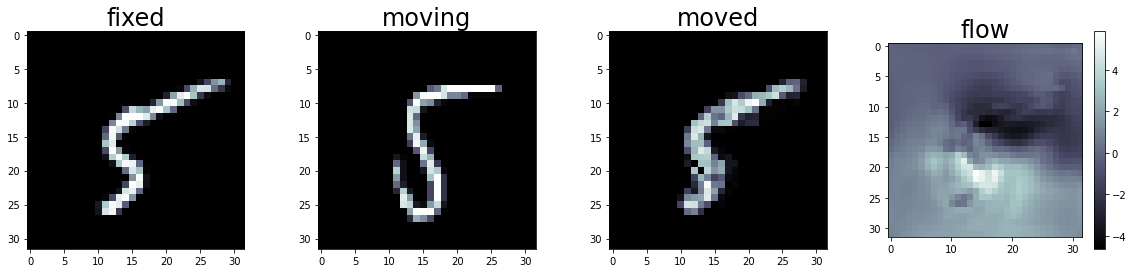

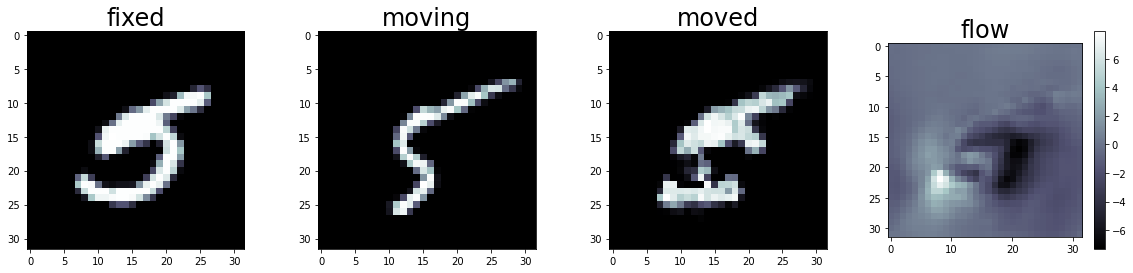

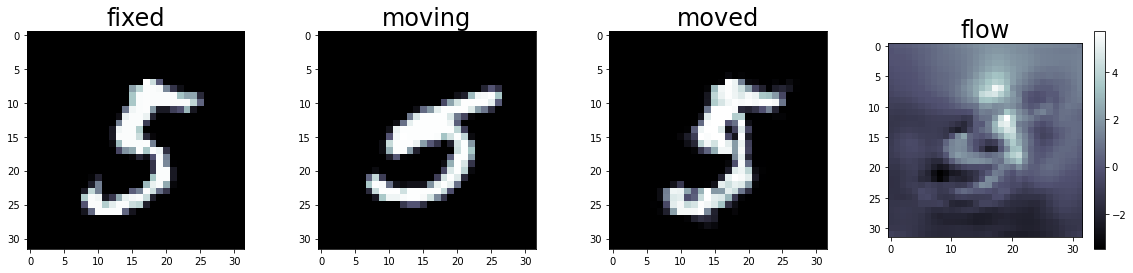

In [87]:
for k in range(8):
    fontsize=24
    cmap=plt.cm.bone
    moving, fixed = test_images[k, 0], test_images[k, 1]
    fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
    ax[0].imshow(fixed, cmap=cmap)
    ax[0].set_title(r'fixed', fontsize=fontsize)
    ax[1].imshow(moving, cmap=cmap)
    ax[1].set_title(r'moving', fontsize=fontsize)
    ax[2].imshow(moved[k, 0], cmap=cmap)
    ax[2].set_title(r'moved', fontsize=fontsize)
    flow = ax[3].imshow(warp[k].sum(0), cmap=cmap)
    ax[3].set_title(r'flow', fontsize=fontsize)
    plt.colorbar(flow, ax=ax[3])
    plt.savefig(f'figures/voxelmorph-five-example-{k}.png')
    plt.show()

### cross domain deformation

In [111]:
shoe_loader = get_dataloader(sneaker_test_dataset, shuffle=False)
five_loader = get_dataloader(five_test_dataset, shuffle=False)

In [112]:
shoe_images = next(iter(shoe_loader)).to('cuda')
five_images = next(iter(five_loader)).to('cuda')

In [113]:
shoe_five_images = torch.stack([shoe_images[:, 0], five_images[:, 0]], 1).to('cuda')
five_shoe_images = torch.stack([five_images[:, 0], shoe_images[:, 0]], 1).to('cuda')

In [114]:
shoe_five_moved, shoe_five_warp = model(shoe_five_images)
shoe_five_images = shoe_five_images.cpu().detach().numpy()
shoe_five_moved = shoe_five_moved.cpu().detach().numpy()
shoe_five_warp = shoe_five_warp.cpu().detach().numpy()

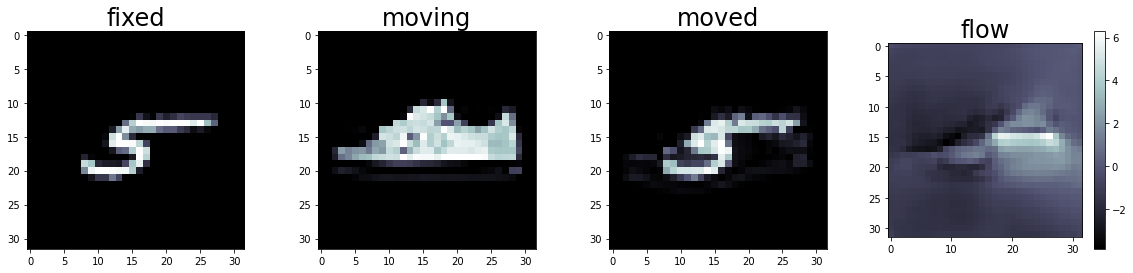

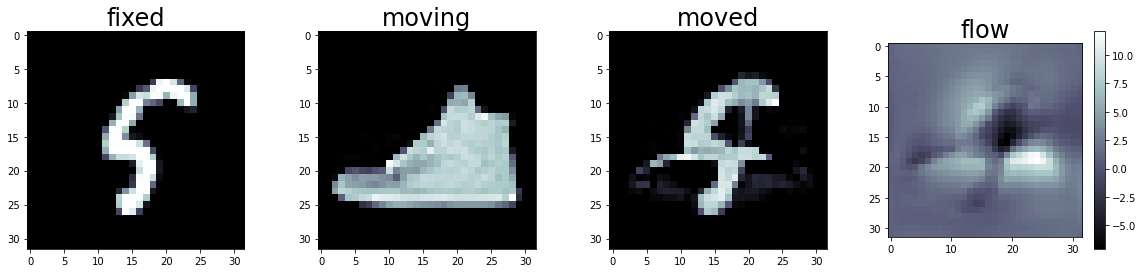

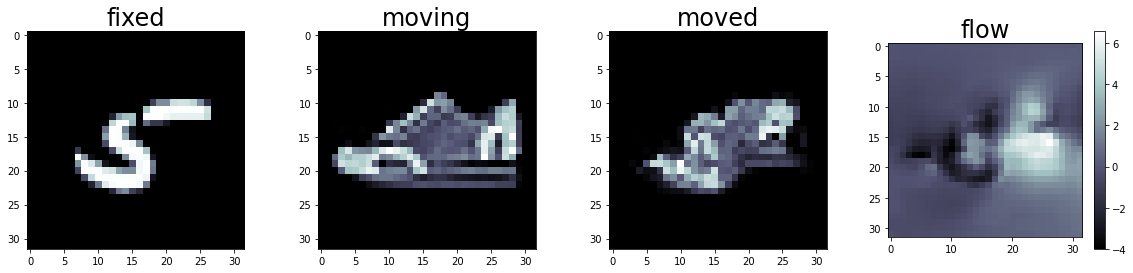

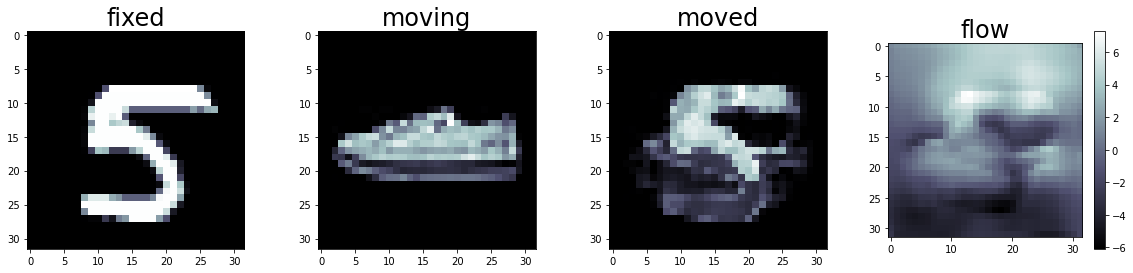

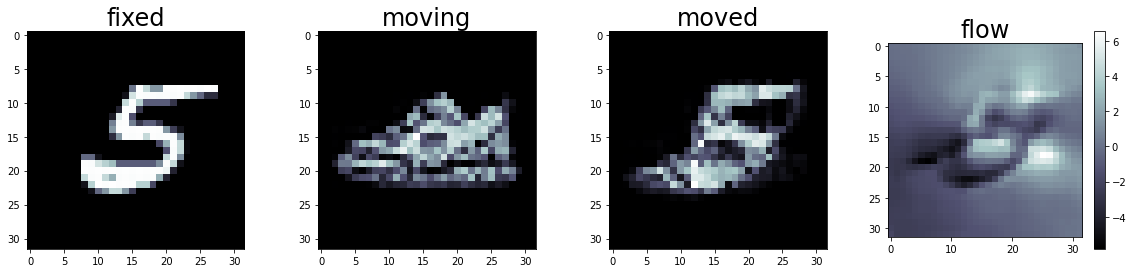

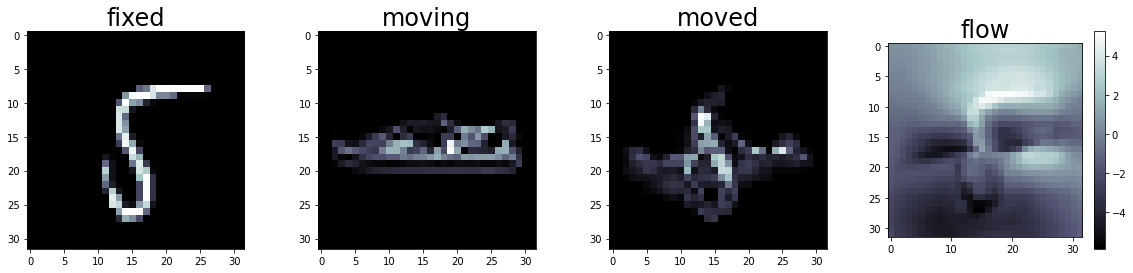

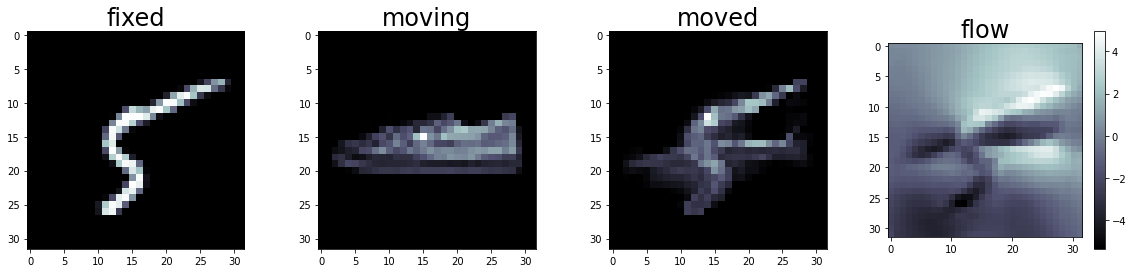

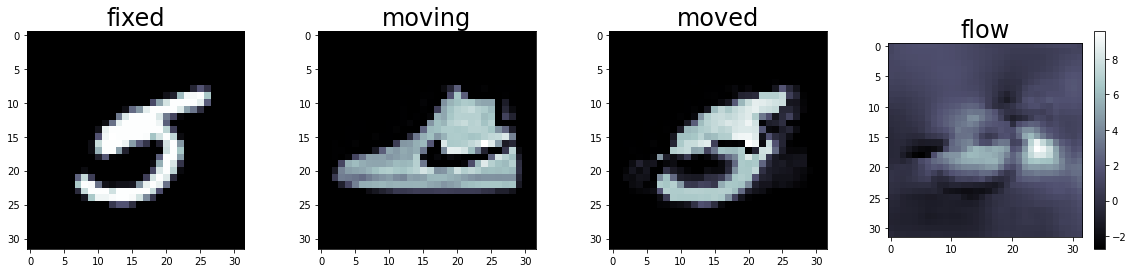

In [115]:
for k in range(8):
    fontsize=24
    cmap=plt.cm.bone
    shoe_five_moving, shoe_five_fixed = shoe_five_images[k, 0], shoe_five_images[k, 1]
    fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
    ax[0].imshow(shoe_five_fixed, cmap=cmap)
    ax[0].set_title(r'fixed', fontsize=fontsize)
    ax[1].imshow(shoe_five_moving, cmap=cmap)
    ax[1].set_title(r'moving', fontsize=fontsize)
    ax[2].imshow(shoe_five_moved[k, 0], cmap=cmap)
    ax[2].set_title(r'moved', fontsize=fontsize)
    shoe_five_flow = ax[3].imshow(shoe_five_warp[k].sum(0), cmap=cmap)
    ax[3].set_title(r'flow', fontsize=fontsize)
    plt.colorbar(shoe_five_flow, ax=ax[3])
    plt.savefig(f'figures/voxelmorph-shoe-to-five-example-{k}.png')
    plt.show()

In [116]:
five_shoe_moved, five_shoe_warp = model(five_shoe_images)
five_shoe_images = five_shoe_images.cpu().detach().numpy()
five_shoe_moved = five_shoe_moved.cpu().detach().numpy()
five_shoe_warp = five_shoe_warp.cpu().detach().numpy()

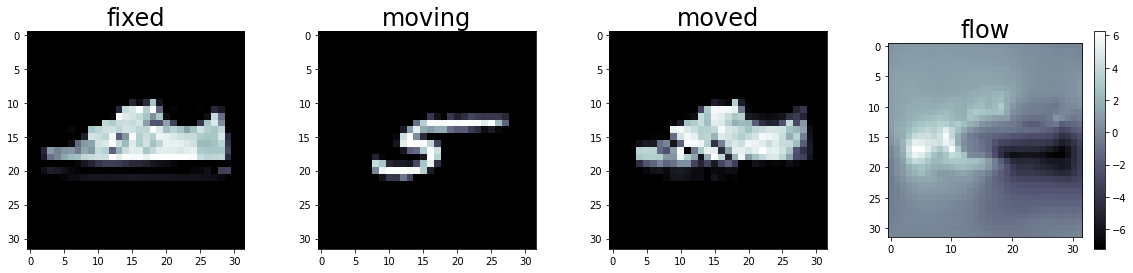

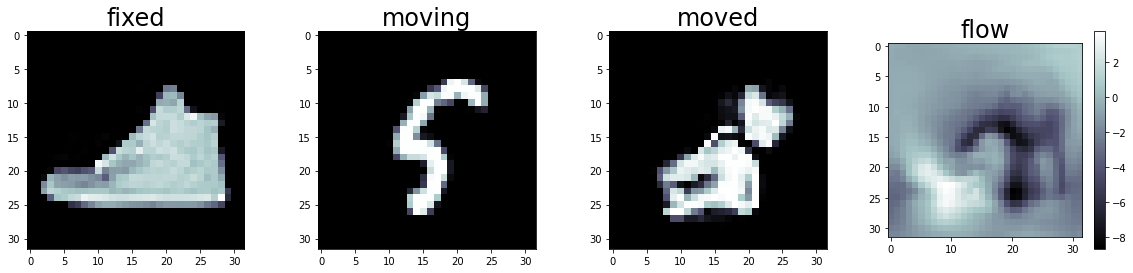

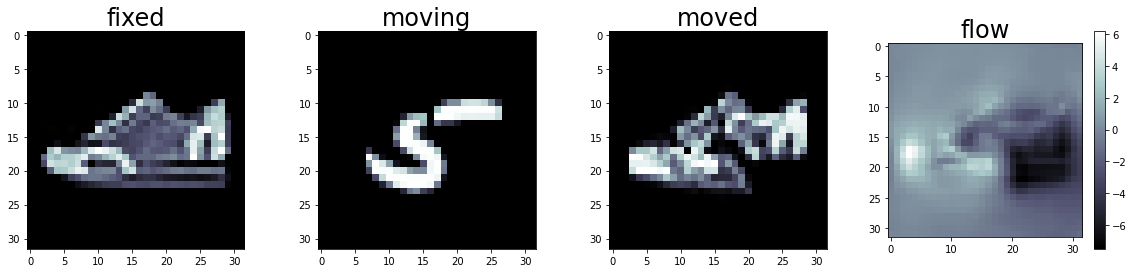

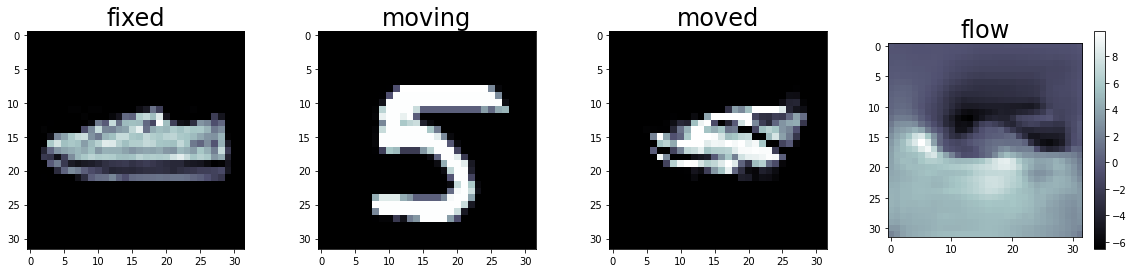

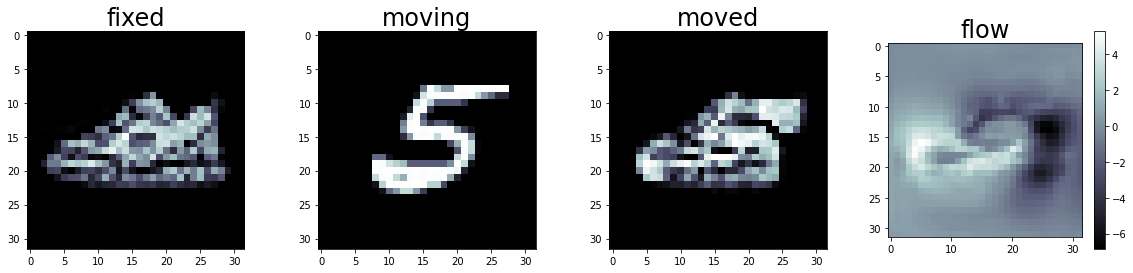

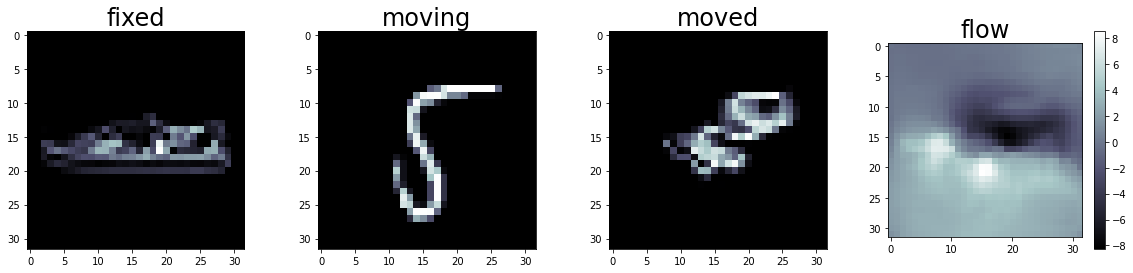

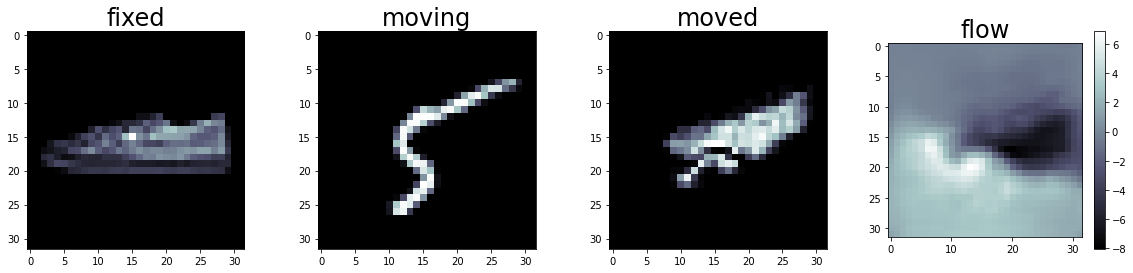

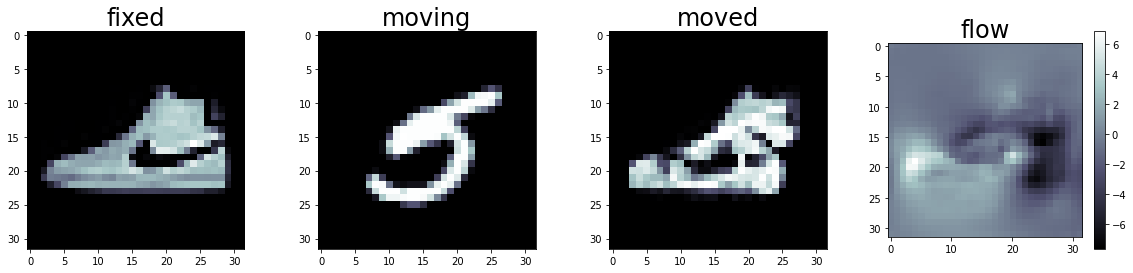

In [117]:
for k in range(8):
    fontsize=24
    cmap=plt.cm.bone
    five_shoe_moving, five_shoe_fixed = five_shoe_images[k, 0], five_shoe_images[k, 1]
    fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
    ax[0].imshow(five_shoe_fixed, cmap=cmap)
    ax[0].set_title(r'fixed', fontsize=fontsize)
    ax[1].imshow(five_shoe_moving, cmap=cmap)
    ax[1].set_title(r'moving', fontsize=fontsize)
    ax[2].imshow(five_shoe_moved[k, 0], cmap=cmap)
    ax[2].set_title(r'moved', fontsize=fontsize)
    five_shoe_flow = ax[3].imshow(five_shoe_warp[k].sum(0), cmap=cmap)
    ax[3].set_title(r'flow', fontsize=fontsize)
    plt.colorbar(five_shoe_flow, ax=ax[3])
    plt.savefig(f'figures/voxelmorph-five-to-shoe-example-{k}.png')
    plt.show()

### domain transfer

### zero-shot learning